# Lending Tree Loan Status: Upsampling
## Classification - Random Forest HPO GPU

## Set Up Environment, Read Data, Split Train/Test Sets

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/RAPIDS/

/content/drive/MyDrive/RAPIDS


In [ ]:
# Clone RAPIDS-Colab install files and see if GPU is compatible
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/env-check.py

In [ ]:
# Update the Colab environment and restart the kernel
!bash rapidsai-csp-utils/colab/update_gcc.sh
import os
os._exit(00)

Updating your Colab environment.  This will restart your kernel.  Don't Panic!
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [813 kB]
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://security.ubuntu.com/ubuntu bionic-security/restrict

In [ ]:
# Install CondaColab and restart the kernel 
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:27
🔁 Restarting kernel...


In [ ]:
# See if environment is ready to install RAPIDS
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


In [ ]:
# Install RAPIDS using the 'stable' release
!python rapidsai-csp-utils/colab/install_rapids.py stable
import os
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'
os.environ['CONDA_PREFIX'] = '/usr/local'

Found existing installation: cffi 1.14.5
Uninstalling cffi-1.14.5:
  Successfully uninstalled cffi-1.14.5
Found existing installation: cryptography 3.4.5
Uninstalling cryptography-3.4.5:
  Successfully uninstalled cryptography-3.4.5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Installing RAPIDS Stable 21.12
Starting the RAPIDS install on Colab.  This will take about 15 minutes.
Solving environment: ...working... WARNING conda.core.solve:_add_specs(611): pinned spec cudatoolkit=11.1 conflicts with explicit specs.  Overriding pinned spec.
failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... WARNING conda.core.solve:_add_specs(611): pinned spec cudatoolkit=11.1 conflicts with explicit specs.  Overriding pinned spec.
failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: ...working... WARNING conda.core.solve:_add_specs(611): pinned spec c

In [ ]:
# Install/import dependencies
!pip install optuna
!pip install dask_optuna
import os
import warnings
import random
import numpy as np
import cupy as cp
from cupy import asnumpy
import dask
from dask.distributed import Client, wait
from dask.diagnostics import ProgressBar
from dask.utils import parse_bytes
from dask_cuda import LocalCUDACluster
import dask_cudf
import dask_optuna
import urllib.request
from contextlib import contextmanager
import time
from datetime import datetime, timedelta
from timeit import default_timer as timer
import cudf
import cuml
from cuml.model_selection import train_test_split
from cuml.ensemble import RandomForestClassifier
import optuna
from optuna import Trial
optuna.logging.set_verbosity(optuna.logging.WARNING) 
import joblib
from joblib import parallel_backend
import pickle
import pandas as pd
import sklearn
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.metrics import recall_score, precision_score
from sklearn.metrics import classification_report, confusion_matrix
import plotly.offline as py
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')
my_dpi=96
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
print('\n')
!/usr/local/cuda/bin/nvcc --version
!nvidia-smi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 7.8 MB/s 
     |████████████████████████████████| 81 kB 10.6 MB/s 
     |████████████████████████████████| 209 kB 41.3 MB/s 
     |████████████████████████████████| 1.6 MB 55.2 MB/s 
     |████████████████████████████████| 150 kB 43.1 MB/s 
     |████████████████████████████████| 78 kB 6.2 MB/s 
     |████████████████████████████████| 49 kB 6.2 MB/s 
     |████████████████████████████████| 146 kB 50.5 MB/s 
     |████████████████████████████████| 112 kB 42.0 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=c3d6bd447db3ecb7606c3d007db0cd6a6526073d71e96423906cfa05c5fe9996
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/si

In [ ]:
# Define function to time code blocks
@contextmanager
def timed(name):
    t0 = time.time()
    yield
    t1 = time.time()
    print('..%-24s:  %8.4f' % (name, t1 - t0))

In [ ]:
# Set up local CUDA cluster for Dask
cluster = LocalCUDACluster(threads_per_worker=1, ip='', dashboard_address='8081') 
c = Client(cluster)

# Query the client for all connected workers
workers = c.has_what().keys()
n_workers = len(workers)
c

<Client: 'tcp://172.28.0.2:38077' processes=1 threads=1, memory=25.46 GiB>

In [ ]:
# Set seed 
seed_value = 42
os.environ['RF_GPU'] = str(seed_value)
random.seed(seed_value)
cp.random.seed(seed_value)
np.random.seed(seed_value)

In [ ]:
%cd /content/drive/MyDrive/LoanStatus/Data/

/content/drive/MyDrive/LoanStatus/Data


In [ ]:
# Read data
trainDF = cudf.read_csv('trainDF_US.csv', low_memory=False)
print('Train set: Number of rows and columns:', trainDF.shape)

testDF = cudf.read_csv('testDF_US.csv', low_memory=False)
print('Test set: Number of rows and columns:', testDF.shape)

Train set: Number of rows and columns: (3022132, 51)
Test set: Number of rows and columns: (432473, 51)


In [ ]:
# Set up features and target
X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')
X_train = X_train.astype('float32')

X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')
X_test = X_test.astype('float32')

## Weighted F1 

### 100 Trials

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/RF/Optuna/TrainTest/Model_PKL

# Define a name for the trials
study_name = 'dask_rf_optuna_US_100_weightedF1_tpe'

/content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_PKL


In [ ]:
# Define function to train/evaluate the model
def train_and_eval(X_param, y_param, bootstrap=True,  
                   n_estimators=100, max_depth=16, 
                   max_leaves=100, min_samples_leaf=30, 
                   min_samples_split=10, n_bins=128): 
    """
        Partition data into train/test sets, train and evaluate the model
        for the given parameters.
        
        Params
        ______
        
        X_param:  DataFrame. 
                  The data to use for training and testing. 
        y_param:  Series. 
                  The label for training

        Returns
        score: weighted F1 of the fitted model
    """
    
    X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')
    X_train = X_train.astype('float32')

    X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')
    X_test = X_test.astype('float32')

    model = RandomForestClassifier(random_state=seed_value, n_streams=1, 
                                   bootstrap=bootstrap, 
                                   n_estimators=n_estimators,
                                   max_depth=max_depth,
                                   max_leaves=max_leaves, 
                                   min_samples_leaf=min_samples_leaf,
                                   min_samples_split=min_samples_split, 
                                   n_bins=n_bins)
    
    # Start timer for each trial
    start = timer()

    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    score = f1_score(asnumpy(y_test), asnumpy(y_pred), average='weighted')
     
    run_time = timer() - start

    print('- Trial time:', run_time) 
    print('- Trial weighted F1:', score)
    print('######################################################')

    return score

In [ ]:
print('Score with default parameters : ', train_and_eval(X_train, y_train))

- Trial time: 25.510474428999714
- Trial weighted F1: 0.9457046872356052
######################################################
Score with default parameters :  0.9457046872356052


In [ ]:
# Define objective function with the parameters to be tested
def objective(trial, X_param, y_param):

    joblib.dump(study, 'RF_Optuna_US_100_GPU_F1weighted.pkl')

    # Search parameters
    n_estimators = trial.suggest_int('n_estimators', 100, 500) 
    max_depth = trial.suggest_int('max_depth', 16, 30) 
    max_leaves = trial.suggest_int('max_leaves', 100, 300) 
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 30, 100)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 30) 
    n_bins = trial.suggest_int('n_bins', 128, 512)
    
    score = train_and_eval(X_param,
                           y_param,
                           bootstrap=True, 
                           n_estimators=n_estimators,
                           max_depth=max_depth,
                           max_leaves=max_leaves, 
                           min_samples_leaf=min_samples_leaf,
                           min_samples_split=min_samples_split, 
                           n_bins=n_bins)

    return score

In [ ]:
with timed('dask_optuna'):
    # Begin HPO trials 
    # Start timer for experiment
    start_time = datetime.now()
    print('%-20s %s' % ('Start Time', start_time))
    if os.path.isfile('RF_Optuna_US_100_GPU_F1weighted.pkl'): 
      study = joblib.load('RF_Optuna_US_100_GPU_F1weighted.pkl')
    else: 
      study = optuna.create_study(sampler=optuna.samplers.TPESampler(), 
                                  study_name=study_name,
                                  direction='maximize')
      
    # Optimize in parallel on Dask cluster
    with parallel_backend('dask'):
        study.optimize(lambda trial: objective(trial, X_train, y_train), 
                       n_trials=100,
                       n_jobs=n_workers)

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Highest F1 Score', study.best_value)

Start Time           2022-06-09 18:21:19.060172
- Trial time: 42.41118593600186
- Trial weighted F1: 0.9519199487925815
######################################################
- Trial time: 89.1064748509998
- Trial weighted F1: 0.9521088598312787
######################################################
- Trial time: 104.23868292200132
- Trial weighted F1: 0.9503092961410854
######################################################
- Trial time: 124.36456535600155
- Trial weighted F1: 0.9551191544917803
######################################################
- Trial time: 50.958007232002274
- Trial weighted F1: 0.9491070182274653
######################################################
- Trial time: 56.14275345400165
- Trial weighted F1: 0.9542681631809281
######################################################
- Trial time: 86.74252882899964
- Trial weighted F1: 0.9513047668902055
######################################################
- Trial time: 111.94315909699799
- Trial weighted F1: 0.95219

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/RF/Optuna/TrainTest/trialOptions/

/content/drive/MyDrive/LoanStatus/ML/RF/Optuna/trialOptions


In [ ]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number':'iteration'}, inplace=True)
trials_df.rename(columns={'value':'f1_weighted'},inplace=True)
trials_df.rename(columns={'params_max_depth':'max_depth'}, inplace=True)
trials_df.rename(columns={'params_max_leaves':'max_leaves'}, inplace=True)
trials_df.rename(columns={'params_min_samples_leaf':'min_samples_leaf'}, 
                 inplace=True)
trials_df.rename(columns={'params_min_samples_split':'min_samples_split'}, 
                 inplace=True)
trials_df.rename(columns={'params_n_bins':'n_bins'}, inplace=True)
trials_df.rename(columns={'params_n_estimators':'n_estimators'}, inplace=True)

# Write processed data to csv
trials_df = trials_df.sort_values('f1_weighted', ascending=False)
trials_df.to_csv('RF_Optuna_US_100_GPU_F1weighted.csv', index=False)
print(trials_df) 

    iteration  f1_weighted             datetime_start  \
83         83     0.958905 2022-06-09 21:00:02.037135   
89         89     0.958343 2022-06-09 21:12:59.821624   
32         32     0.958229 2022-06-09 19:16:27.476072   
49         49     0.958207 2022-06-09 19:50:28.556057   
91         91     0.958124 2022-06-09 21:17:16.858284   
..        ...          ...                        ...   
28         28     0.947672 2022-06-09 19:09:33.271205   
85         85     0.946905 2022-06-09 21:04:26.753009   
10         10     0.946758 2022-06-09 18:35:12.636628   
66         66     0.946064 2022-06-09 20:26:52.478211   
99         99          NaN 2022-06-09 21:34:23.261973   

            datetime_complete               duration  max_depth  max_leaves  \
83 2022-06-09 21:02:19.462899 0 days 00:02:17.425764       29.0       300.0   
89 2022-06-09 21:15:08.282905 0 days 00:02:08.461281       24.0       291.0   
32 2022-06-09 19:18:44.130927 0 days 00:02:16.654855       24.0       299.0   

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/RF/Optuna/TrainTest/Model_Explanations/

/content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_Explanations


In [ ]:
# Plot_optimization_history: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_RF_Optuna_US_100_GPU_F1weighted.html')
fig.show()

In [ ]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_RF_Optuna_US_100_GPU_F1weighted.html')
fig.show()

In [ ]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_RF_Optuna_US_100_GPU_F1weighted.html')
fig.show()

In [ ]:
# plot_contour: plots parameter interactions on an interactive chart. 
fig = optuna.visualization.plot_contour(study, params=['max_leaves', 
                                                       'min_samples_leaf',
                                                       'max_depth', 
                                                       'min_samples_split'])
py.plot(fig, filename='contour_RF_Optuna_US_100_GPU_F1weighted.html')
fig.show()

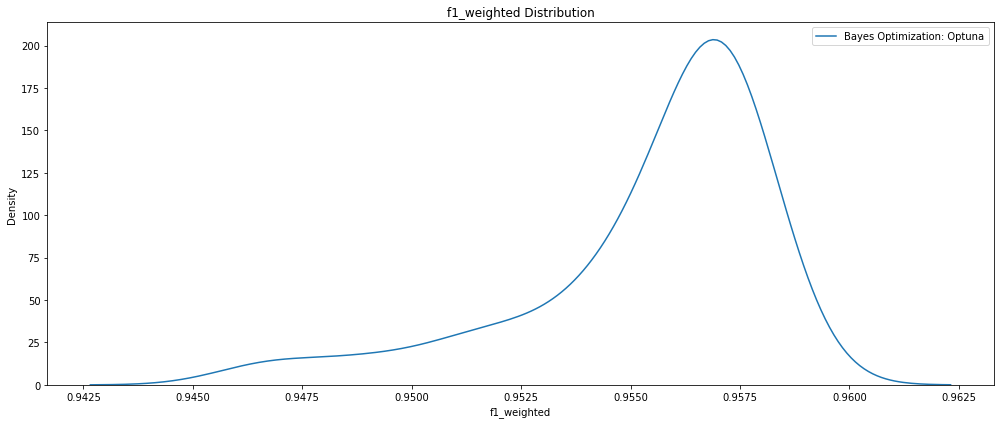

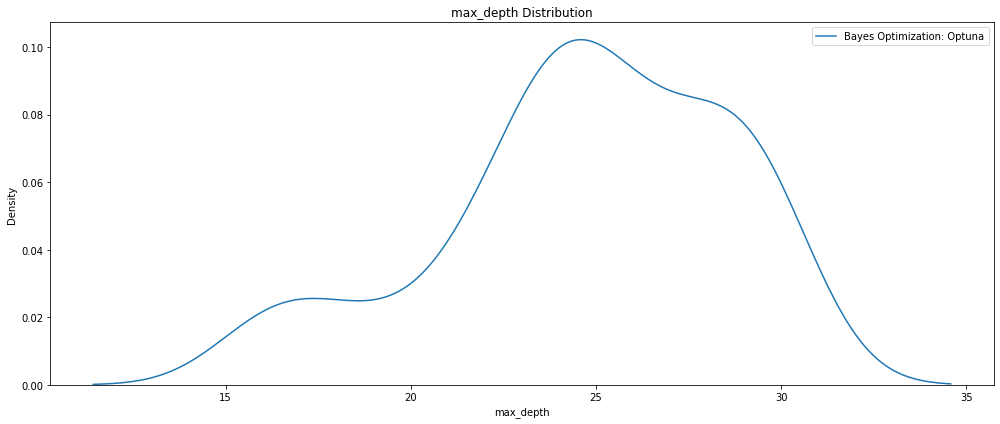

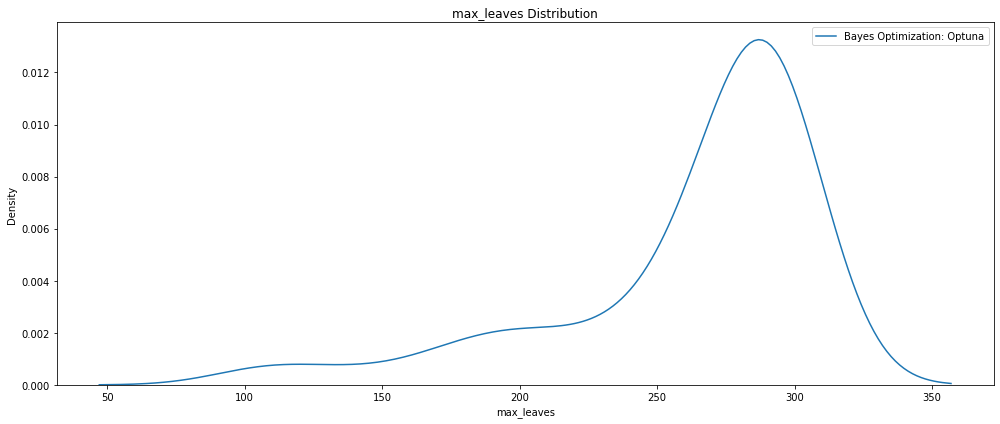

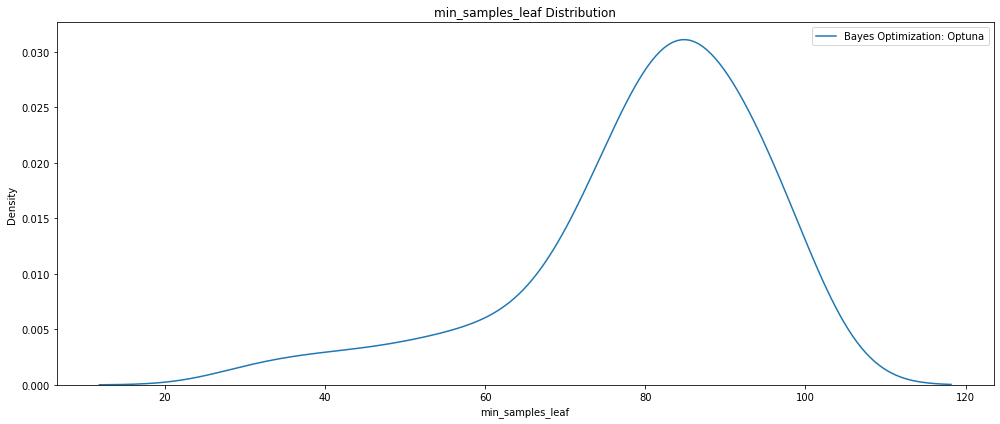

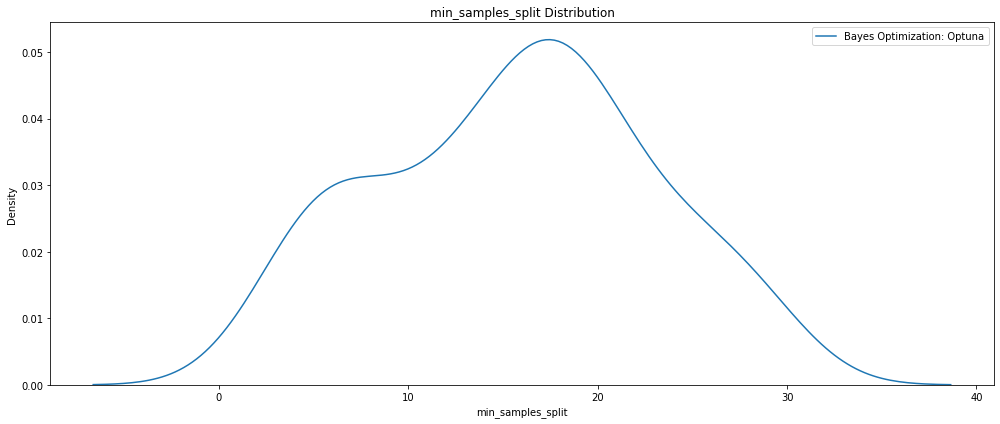

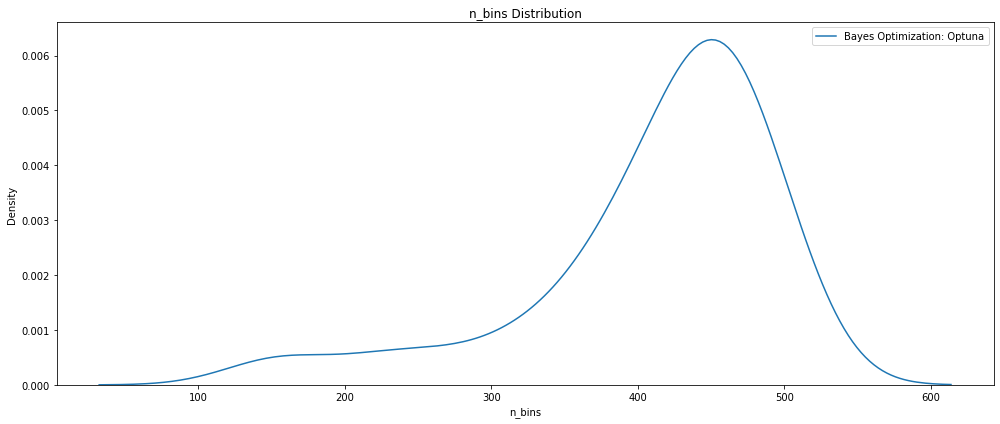

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'datetime_start', 'datetime_complete',
                   'duration','n_estimators', 'state']:
        plt.figure(figsize=(14,6))
        # Plot the random search distribution and the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label='Bayes Optimization: Optuna')
            plt.legend(loc = 0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

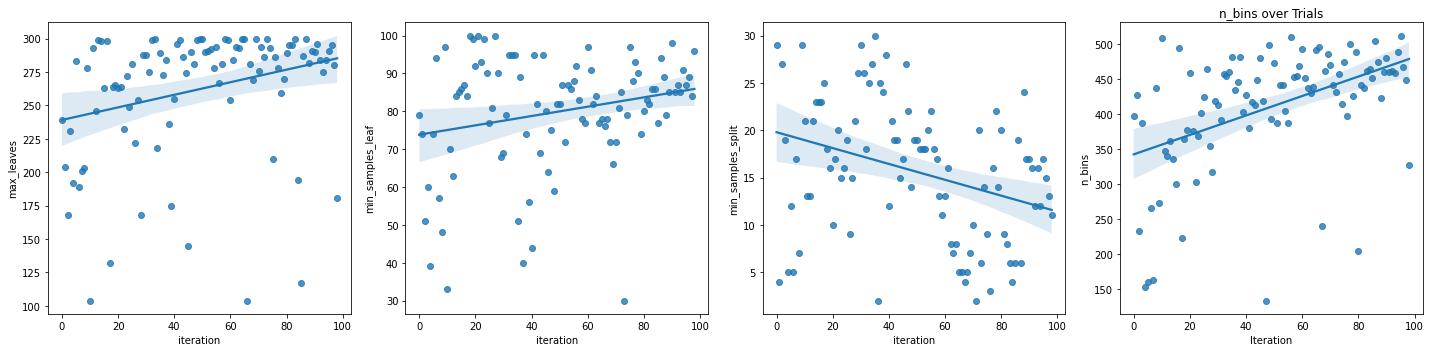

In [ ]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(1, 4, figsize=(20,5))
i = 0
axs = axs.flatten()
for i, hpo in enumerate(['max_leaves', 'min_samples_leaf', 'min_samples_split',
                         'n_bins']): 
                         # Scatterplot
                         sns.regplot('iteration', hpo, data=trials_df, ax=axs[i]) 
                         axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo),  
                                    title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

In [ ]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_RF_Optuna_US_100_GPU_F1weighted.html')
fig.show()

In [ ]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_RF_Optuna_US_100_GPU_F1weighted.html')
fig.show()

In [ ]:
# Arrange best parameters to fit model for model metrics
params = study.best_params   
params['random_state'] = seed_value
params

{'max_depth': 29,
 'max_leaves': 300,
 'min_samples_leaf': 86,
 'min_samples_split': 6,
 'n_bins': 462,
 'n_estimators': 488,
 'random_state': 42}

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/RF/Optuna/TrainTest/Model_PKL/

/content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_PKL


In [ ]:
# Set up train/test split
X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')
X_train = X_train.astype('float32')

X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')
X_test = X_test.astype('float32')

In [ ]:
# Re-create the best model and train on the training data
best_model = RandomForestClassifier(n_streams=1, 
                                    **params)

# Fit the model
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'RF_Optuna_US_trials100_GPU_F1weighted.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('RF_Optuna_US_trials100_GPU_F1weighted.pkl')
# print(model)
# =============================================================================

In [ ]:
print('\nModel Metrics for RF HPO Upsampling 100trials GPU')
# Predict based on training 
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

print('\n')
print('Classification Report:')
clf_rpt = classification_report(asnumpy(y_test), asnumpy(y_test_pred))
print(clf_rpt)
print('\n')
print('Confusion matrix:')
print(confusion_matrix(asnumpy(y_test), asnumpy(y_test_pred)))
print('\n')
print('Accuracy score : %.3f' % accuracy_score(asnumpy(y_test), 
                                               asnumpy(y_test_pred)))
print('Precision score : %.3f' % precision_score(asnumpy(y_test), 
                                                 asnumpy(y_test_pred)))
print('Recall score : %.3f' % recall_score(asnumpy(y_test), 
                                           asnumpy(y_test_pred)))
print('F1 score : %.3f' % f1_score(asnumpy(y_test), asnumpy(y_test_pred)))


Model Metrics for RF HPO Upsampling 100trials GPU


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98    377848
           1       0.79      0.91      0.84     54625

    accuracy                           0.96    432473
   macro avg       0.89      0.94      0.91    432473
weighted avg       0.96      0.96      0.96    432473



Confusion matrix:
[[364559  13289]
 [  5026  49599]]


Accuracy score : 0.958
Precision score : 0.789
Recall score : 0.908
F1 score : 0.844


In [ ]:
# Evaluate on the testing data 
print('The best model from Upsampling 100 GPU trials optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(asnumpy(y_test), 
                                                                                                                               asnumpy(y_test_pred))))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from Upsampling 100 GPU trials optimization scores 0.93641 AUC ROC on the test set.
This was achieved using these conditions:
iteration                                    83
f1_weighted                            0.958905
datetime_start       2022-06-09 21:00:02.037135
datetime_complete    2022-06-09 21:02:19.462899
duration                 0 days 00:02:17.425764
max_depth                                  29.0
max_leaves                                300.0
min_samples_leaf                           86.0
min_samples_split                           6.0
n_bins                                    462.0
n_estimators                              488.0
state                                  COMPLETE
Name: 83, dtype: object


### 300 Trials

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/RF/Optuna/TrainTest/Model_PKL

# Define a name for the trials
study_name = 'dask_rf_optuna_US_300_weightedF1_tpe'

/content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_PKL


In [ ]:
# Define objective function with the parameters to be tested
def objective(trial, X_param, y_param):

    joblib.dump(study, 'RF_Optuna_US_300_GPU_F1weighted.pkl')

    # Search parameters
    n_estimators = trial.suggest_int('n_estimators', 200, 700) 
    max_depth = trial.suggest_int('max_depth', 15, 50) 
    max_leaves = trial.suggest_int('max_leaves', 200, 500) 
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 30, 150)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 30) 
    n_bins = trial.suggest_int('n_bins', 128, 512)
    
    score = train_and_eval(X_param,
                           y_param,
                           bootstrap=True, 
                           n_estimators=n_estimators,
                           max_depth=max_depth,
                           max_leaves=max_leaves, 
                           min_samples_leaf=min_samples_leaf,
                           min_samples_split=min_samples_split, 
                           n_bins=n_bins)

    return score

In [ ]:
with timed('dask_optuna'):
    # Begin HPO trials 
    # Start timer for experiment
    start_time = datetime.now()
    print('%-20s %s' % ('Start Time', start_time))
    if os.path.isfile('RF_Optuna_US_300_GPU_F1weighted.pkl'): 
      study = joblib.load('RF_Optuna_US_300_GPU_F1weighted.pkl')
    else: 
      study = optuna.create_study(sampler=optuna.samplers.TPESampler(), 
                                  study_name=study_name,
                                  direction='maximize')
      
    # Optimize in parallel on Dask cluster
    with parallel_backend('dask'):
        study.optimize(lambda trial: objective(trial, X_train, y_train), 
                       n_trials=300,
                       n_jobs=n_workers)

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Highest F1 Score', study.best_value)

Start Time           2022-06-10 13:22:23.517445
- Trial time: 189.495685719
- Trial weighted F1: 0.963672690278254
######################################################
- Trial time: 181.68432001600013
- Trial weighted F1: 0.9628681712317179
######################################################
- Trial time: 174.40520138300008
- Trial weighted F1: 0.9631545823056463
######################################################
- Trial time: 185.2196995889999
- Trial weighted F1: 0.9635067507904448
######################################################
- Trial time: 173.05307158100004
- Trial weighted F1: 0.9628007251710123
######################################################
- Trial time: 145.6525261009997
- Trial weighted F1: 0.9633948486398649
######################################################
- Trial time: 191.35419689900027
- Trial weighted F1: 0.9631198620254049
######################################################
- Trial time: 175.42667446799987
- Trial weighted F1: 0.96371590

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/RF/Optuna/TrainTest/trialOptions/

/content/drive/MyDrive/LoanStatus/ML/RF/Optuna/trialOptions


In [ ]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number':'iteration'}, inplace=True)
trials_df.rename(columns={'value':'f1_weighted'},inplace=True)
trials_df.rename(columns={'params_max_depth':'max_depth'}, inplace=True)
trials_df.rename(columns={'params_max_leaves':'max_leaves'}, inplace=True)
trials_df.rename(columns={'params_min_samples_leaf':'min_samples_leaf'}, 
                 inplace=True)
trials_df.rename(columns={'params_min_samples_split':'min_samples_split'}, 
                 inplace=True)
trials_df.rename(columns={'params_n_bins':'n_bins'}, inplace=True)
trials_df.rename(columns={'params_n_estimators':'n_estimators'}, inplace=True)

# Write processed data to csv
trials_df = trials_df.sort_values('f1_weighted', ascending=False)
trials_df.to_csv('RF_Optuna_US_300_GPU_F1weighted.csv', index=False)
print(trials_df) 

     iteration  f1_weighted             datetime_start  \
289        289     0.964360 2022-06-10 16:47:27.653812   
253        253     0.964292 2022-06-10 14:50:15.343012   
250        250     0.964177 2022-06-10 14:40:33.854289   
204        204     0.964164 2022-06-10 05:44:12.427653   
296        296     0.964158 2022-06-10 17:08:19.597719   
..         ...          ...                        ...   
80          80     0.954967 2022-06-10 00:15:49.351092   
16          16     0.954239 2022-06-09 22:08:45.237496   
47          47     0.953762 2022-06-09 23:11:58.511398   
13          13     0.951733 2022-06-09 22:03:36.927234   
222        222          NaN 2022-06-10 06:37:32.075722   

             datetime_complete               duration  max_depth  max_leaves  \
289 2022-06-10 16:50:35.475033 0 days 00:03:07.821221       42.0       500.0   
253 2022-06-10 14:53:29.440234 0 days 00:03:14.097222       41.0       499.0   
250 2022-06-10 14:43:48.341958 0 days 00:03:14.487669       41.

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/RF/Optuna/TrainTest/Model_Explanations/

/content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_Explanations


In [ ]:
# Plot_optimization_history: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_RF_Optuna_US_300_GPU_F1weighted.html')
fig.show()

In [ ]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_RF_Optuna_US_300_GPU_F1weighted.html')
fig.show()

In [ ]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_RF_Optuna_US_300_GPU_F1weighted.html')
fig.show()

In [ ]:
# plot_contour: plots parameter interactions on an interactive chart. 
fig = optuna.visualization.plot_contour(study, params=['max_leaves', 
                                                       'min_samples_leaf',
                                                       'max_depth', 
                                                       'min_samples_split'])
py.plot(fig, filename='contour_RF_Optuna_US_300_GPU_F1weighted.html')
fig.show()

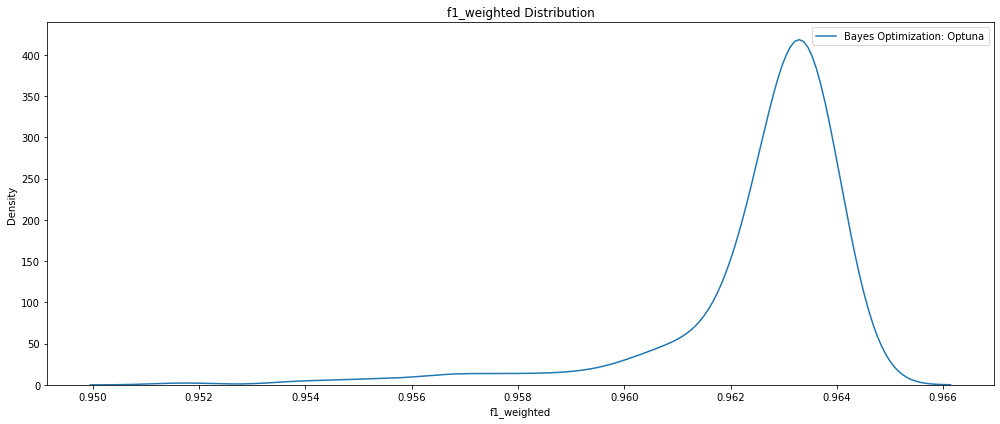

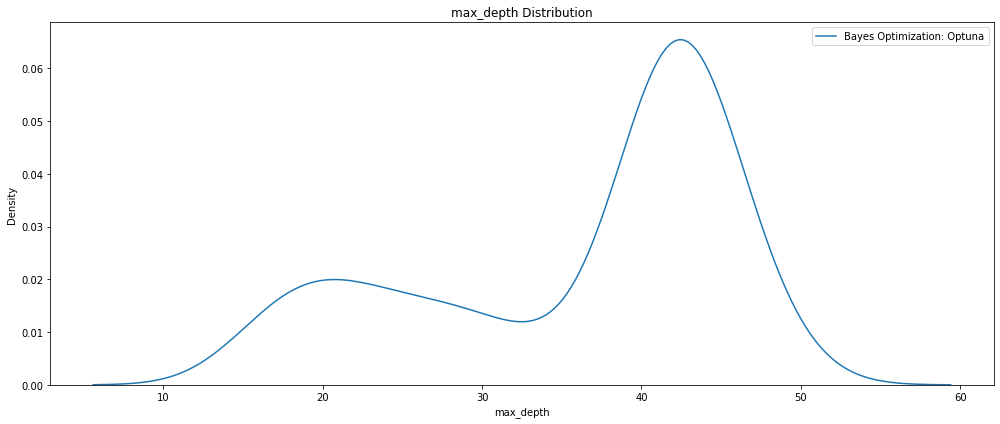

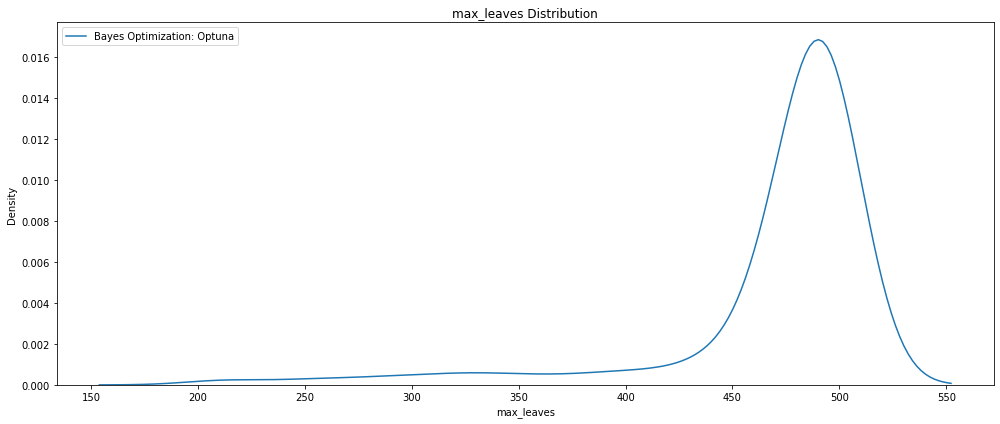

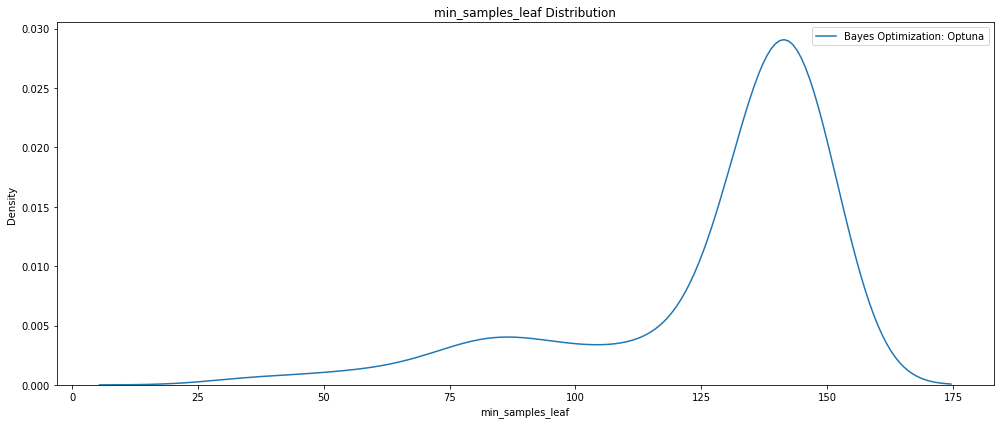

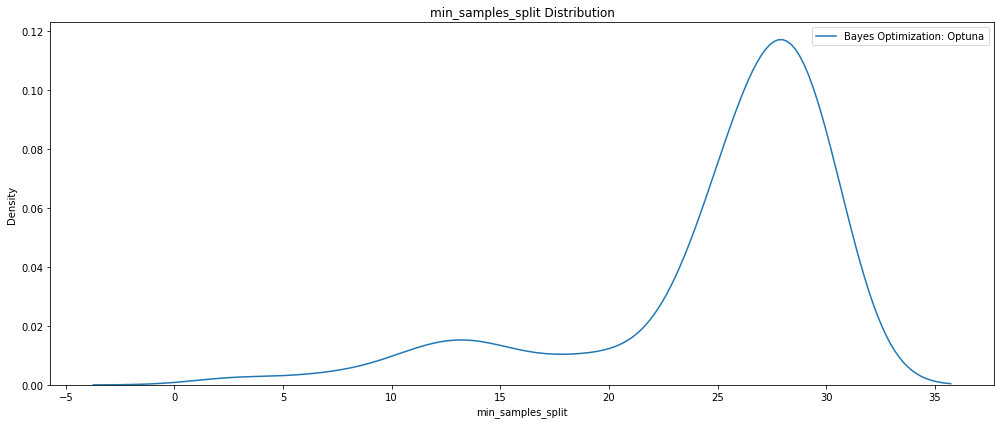

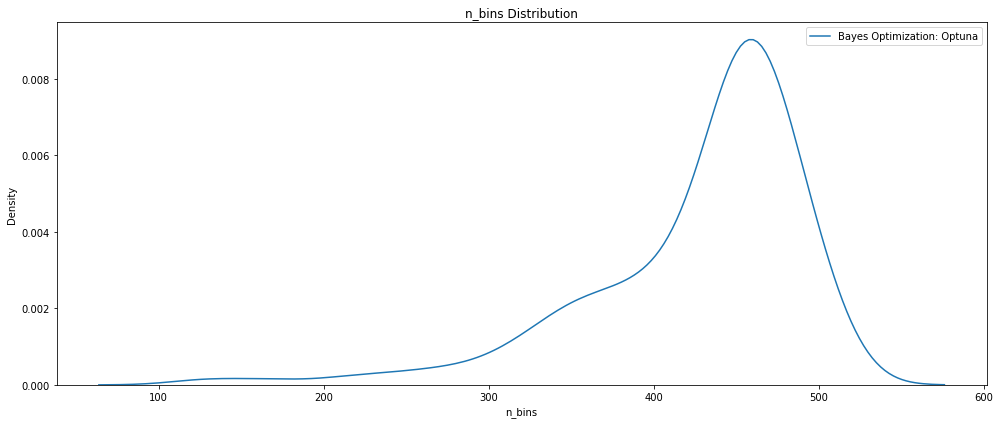

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'datetime_start', 'datetime_complete',
                   'duration','n_estimators', 'state']:
        plt.figure(figsize=(14,6))
        # Plot the random search distribution and the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label='Bayes Optimization: Optuna')
            plt.legend(loc = 0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

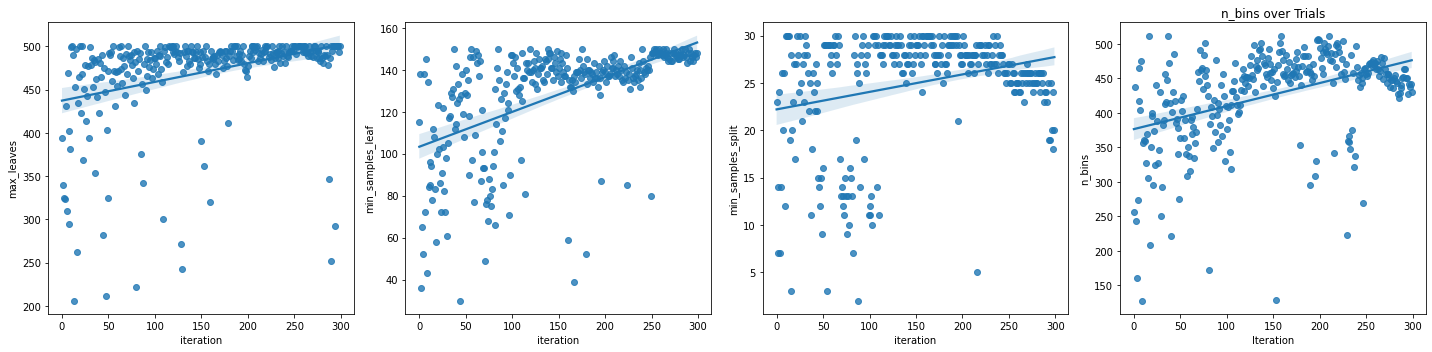

In [ ]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(1, 4, figsize=(20,5))
i = 0
axs = axs.flatten()
for i, hpo in enumerate(['max_leaves', 'min_samples_leaf', 'min_samples_split',
                         'n_bins']): 
                         # Scatterplot
                         sns.regplot('iteration', hpo, data=trials_df, ax=axs[i]) 
                         axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo),  
                                    title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/RF/Optuna/TrainTest/Model_Explanations/

/content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_Explanations


In [ ]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_RF_Optuna_US_300_GPU_F1weighted.html')
fig.show()

In [ ]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_RF_Optuna_US_300_GPU_F1weighted.html')
fig.show()

In [ ]:
# Arrange best parameters to fit model for model metrics
params = study.best_params   
params['random_state'] = seed_value
params

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/RF/Optuna/TrainTest/Model_PKL/

In [ ]:
# Set up train/test split
X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')
X_train = X_train.astype('float32')

X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')
X_test = X_test.astype('float32')

In [ ]:
# Re-create the best model and train on the training data
best_model = RandomForestClassifier(n_streams=1, 
                                    **params)

# Fit the model
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'RF_Optuna_US_trials300_GPU_F1weighted.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('RF_Optuna_US_trials300_GPU_F1weighted.pkl')
# print(model)
# =============================================================================

In [ ]:
print('\nModel Metrics for RF HPO Upsampling 300trials GPU')
# Predict based on training 
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

print('\n')
print('Classification Report:')
clf_rpt = classification_report(asnumpy(y_test), asnumpy(y_test_pred))
print(clf_rpt)
print('\n')
print('Confusion matrix:')
print(confusion_matrix(asnumpy(y_test), asnumpy(y_test_pred)))
print('\n')
print('Accuracy score : %.3f' % accuracy_score(asnumpy(y_test), 
                                               asnumpy(y_test_pred)))
print('Precision score : %.3f' % precision_score(asnumpy(y_test), 
                                                 asnumpy(y_test_pred)))
print('Recall score : %.3f' % recall_score(asnumpy(y_test), 
                                           asnumpy(y_test_pred)))
print('F1 score : %.3f' % f1_score(asnumpy(y_test), asnumpy(y_test_pred)))


Model Metrics for RF HPO Upsampling 300trials GPU


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98    377848
           1       0.82      0.91      0.86     54625

    accuracy                           0.96    432473
   macro avg       0.90      0.94      0.92    432473
weighted avg       0.97      0.96      0.96    432473



Confusion matrix:
[[366973  10875]
 [  4885  49740]]


Accuracy score : 0.964
Precision score : 0.821
Recall score : 0.911
F1 score : 0.863


In [ ]:
# Evaluate on the testing data 
print('The best model from Upsampling 300 GPU trials optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(asnumpy(y_test), 
                                                                                                                               asnumpy(y_test_pred))))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from Upsampling 300 GPU trials optimization scores 0.94090 AUC ROC on the test set.
This was achieved using these conditions:
iteration                                   289
f1_weighted                             0.96436
datetime_start       2022-06-10 16:47:27.653812
datetime_complete    2022-06-10 16:50:35.475033
duration                 0 days 00:03:07.821221
max_depth                                  42.0
max_leaves                                500.0
min_samples_leaf                          148.0
min_samples_split                          24.0
n_bins                                    450.0
n_estimators                              645.0
state                                  COMPLETE
Name: 289, dtype: object


## Weighted ROC

### 100 Trials

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/RF/Optuna/TrainTest/Model_PKL

# Define a name for the trials
study_name = 'dask_rf_optuna_US_100_weightedROC_tpe'

/content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_PKL


In [ ]:
# Define function to train/evaluate the model
def train_and_eval(X_param, y_param, bootstrap=True,  
                   n_estimators=100, max_depth=16, 
                   max_leaves=100, min_samples_leaf=30, 
                   min_samples_split=10, n_bins=128): 
    """
        Partition data into train/test sets, train and evaluate the model
        for the given parameters.
        
        Params
        ______
        
        X_param:  DataFrame. 
                  The data to use for training and testing. 
        y_param:  Series. 
                  The label for training

        Returns
        score: Weighted ROC of the fitted model
    """
    
    X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')
    X_train = X_train.astype('float32')

    X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')
    X_test = X_test.astype('float32')

    model = RandomForestClassifier(random_state=seed_value, n_streams=1, 
                                   bootstrap=bootstrap, 
                                   n_estimators=n_estimators,
                                   max_depth=max_depth,
                                   max_leaves=max_leaves, 
                                   min_samples_leaf=min_samples_leaf,
                                   min_samples_split=min_samples_split, 
                                   n_bins=n_bins)
    
    # Start timer for each trial
    start = timer()

    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    score = roc_auc_score(asnumpy(y_test), asnumpy(y_pred)), 
                          average='weighted') 
     
    run_time = timer() - start

    print('- Trial time:', run_time) 
    print('- Trial weighted ROC:', score)
    print('######################################################')

    return score

In [ ]:
print('Score with default parameters : ', train_and_eval(X_train, y_train))

- Trial time: 25.385213363999355
- Trial weighted ROC: 0.9190358779264307
######################################################
Score with default parameters :  0.9190358779264307


In [ ]:
# Define objective function with the parameters to be tested
def objective(trial, X_param, y_param):

    joblib.dump(study, 'RF_Optuna_US_100_GPU_ROCweighted.pkl')

    # Search parameters
    n_estimators = trial.suggest_int('n_estimators', 100, 500) 
    max_depth = trial.suggest_int('max_depth', 16, 30) 
    max_leaves = trial.suggest_int('max_leaves', 100, 300) 
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 30, 100)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 30) 
    n_bins = trial.suggest_int('n_bins', 128, 512)
    
    score = train_and_eval(X_param,
                           y_param,
                           bootstrap=True, 
                           n_estimators=n_estimators,
                           max_depth=max_depth,
                           max_leaves=max_leaves, 
                           min_samples_leaf=min_samples_leaf,
                           min_samples_split=min_samples_split, 
                           n_bins=n_bins)

    return score

In [ ]:
with timed('dask_optuna'):
    # Begin HPO trials 
    # Start timer for experiment
    start_time = datetime.now()
    print('%-20s %s' % ('Start Time', start_time))
    if os.path.isfile('RF_Optuna_US_100_GPU_ROCweighted.pkl'): 
      study = joblib.load('RF_Optuna_US_100_GPU_ROCweighted.pkl')
    else: 
      study = optuna.create_study(sampler=optuna.samplers.TPESampler(), 
                                  study_name=study_name,
                                  direction='maximize')
      
    # Optimize in parallel on Dask cluster
    with parallel_backend('dask'):
        study.optimize(lambda trial: objective(trial, X_train, y_train), 
                       n_trials=100,
                       n_jobs=n_workers)

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Highest ROCweighted score', study.best_value)

Start Time           2022-06-10 17:32:32.324487
- Trial time: 63.91952372399828
- Trial weighted ROC: 0.9281868128101298
######################################################
- Trial time: 36.38703430299938
- Trial weighted ROC: 0.9249447686808498
######################################################
- Trial time: 81.22944993200144
- Trial weighted ROC: 0.9331173152721758
######################################################
- Trial time: 97.04037897800299
- Trial weighted ROC: 0.926236432147815
######################################################
- Trial time: 94.54306178000115
- Trial weighted ROC: 0.9266153590413774
######################################################
- Trial time: 100.0847099010025
- Trial weighted ROC: 0.9349142977208227
######################################################
- Trial time: 120.25175854700137
- Trial weighted ROC: 0.9287659649998133
######################################################
- Trial time: 116.56542586900105
- Trial weighted ROC: 0

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/RF/Optuna/TrainTest/trialOptions/

/content/drive/MyDrive/LoanStatus/ML/RF/Optuna/trialOptions


In [ ]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number':'iteration'}, inplace=True)
trials_df.rename(columns={'value':'roc_weighted'},inplace=True)
trials_df.rename(columns={'params_max_depth':'max_depth'}, inplace=True)
trials_df.rename(columns={'params_max_leaves':'max_leaves'}, inplace=True)
trials_df.rename(columns={'params_min_samples_leaf':'min_samples_leaf'}, 
                 inplace=True)
trials_df.rename(columns={'params_min_samples_split':'min_samples_split'}, 
                 inplace=True)
trials_df.rename(columns={'params_n_bins':'n_bins'}, inplace=True)
trials_df.rename(columns={'params_n_estimators':'n_estimators'}, inplace=True)

# Write processed data to csv
trials_df = trials_df.sort_values('roc_weighted', ascending=False)
trials_df.to_csv('RF_Optuna_US_100_GPU_ROCweighted.csv', index=False)
print(trials_df) 

    iteration  roc_weighted             datetime_start  \
67         67      0.935821 2022-06-10 19:29:55.956892   
66         66      0.935736 2022-06-10 19:27:45.612234   
10         10      0.935696 2022-06-10 17:47:08.520969   
99         99      0.935692 2022-06-10 20:36:14.049723   
41         41      0.935634 2022-06-10 18:35:53.934287   
..        ...           ...                        ...   
4           4      0.926615 2022-06-10 17:37:11.520707   
3           3      0.926236 2022-06-10 17:35:34.294415   
1           1      0.924945 2022-06-10 17:33:36.374316   
7           7      0.924921 2022-06-10 17:42:26.869189   
38         38      0.923383 2022-06-10 18:31:47.336155   

            datetime_complete               duration  max_depth  max_leaves  \
67 2022-06-10 19:32:07.134769 0 days 00:02:11.177877         26         277   
66 2022-06-10 19:29:55.956756 0 days 00:02:10.344522         23         292   
10 2022-06-10 17:49:26.020190 0 days 00:02:17.499221         26   

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/RF/Optuna/TrainTest/Model_Explanations/

/content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_Explanations


In [ ]:
# Plot_optimization_history: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_RF_Optuna_US_100_GPU_ROCweighted.html')
fig.show()

In [ ]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_RF_Optuna_US_100_GPU_ROCweighted.html')
fig.show()

In [ ]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_RF_Optuna_US_100_GPU_ROCweighted.html')
fig.show()

In [ ]:
# plot_contour: plots parameter interactions on an interactive chart. 
fig = optuna.visualization.plot_contour(study, params=['max_leaves', 
                                                       'min_samples_leaf',
                                                       'max_depth', 
                                                       'min_samples_split'])
py.plot(fig, filename='contour_RF_Optuna_US_100_GPU_ROCweighted.html')
fig.show()

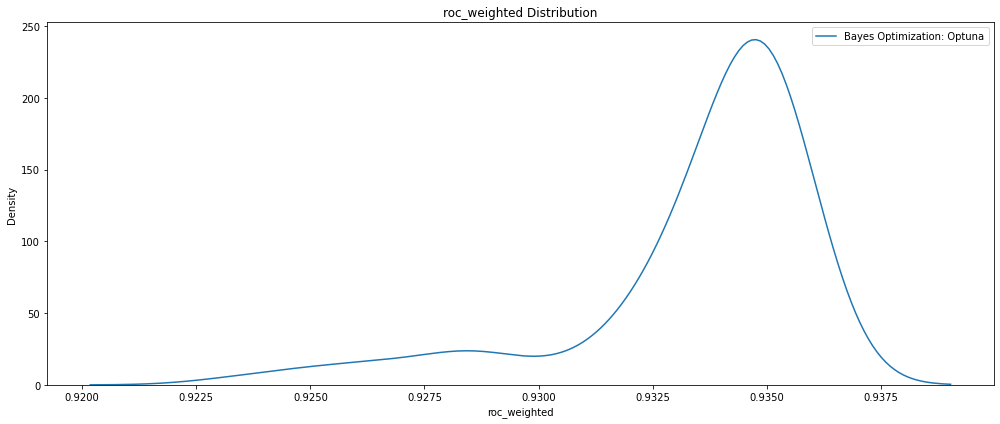

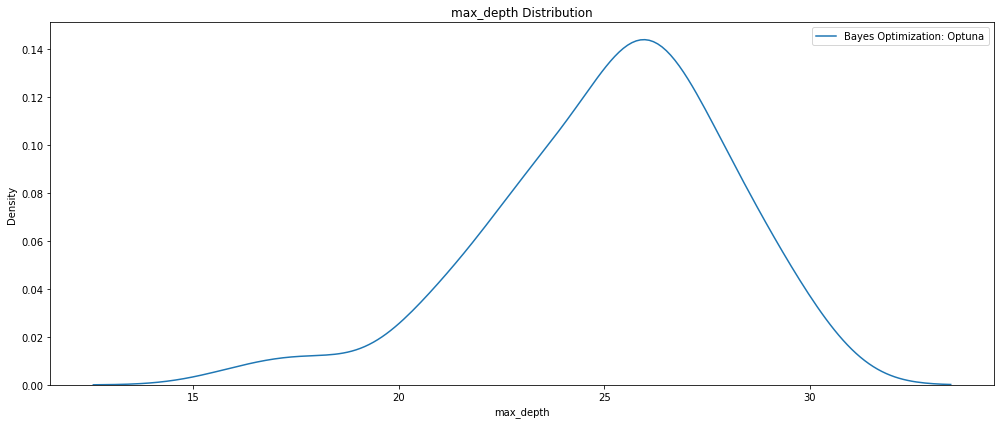

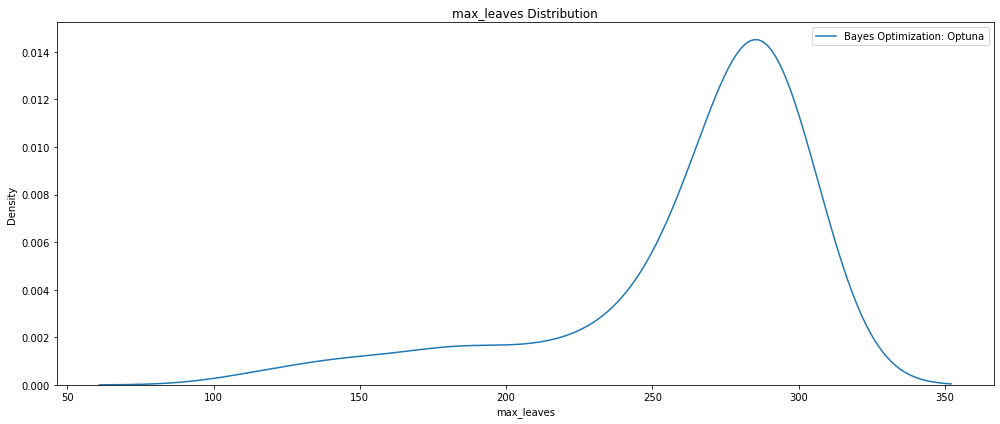

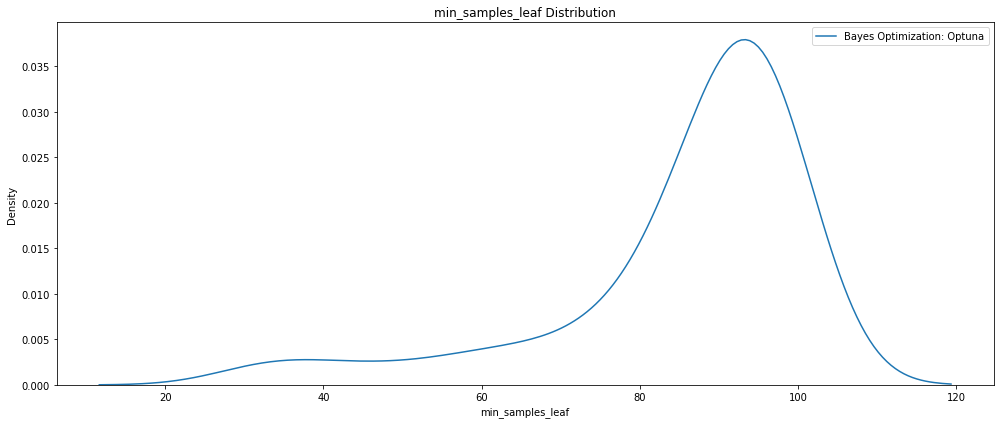

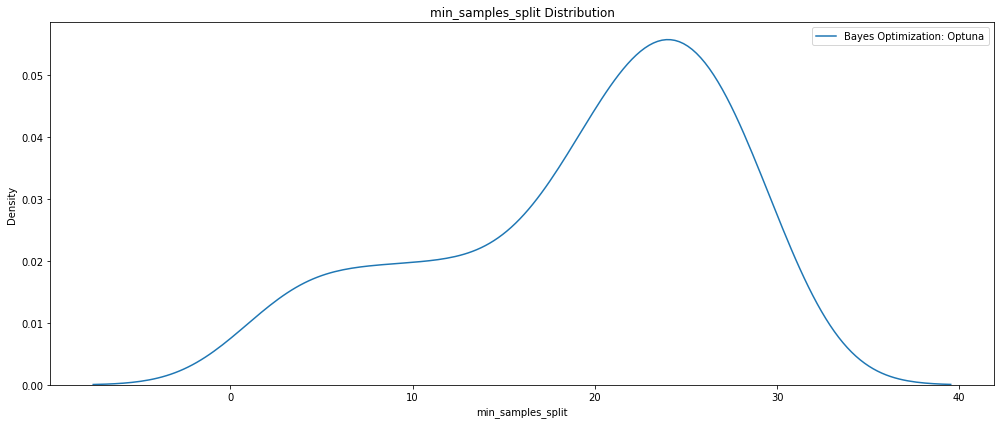

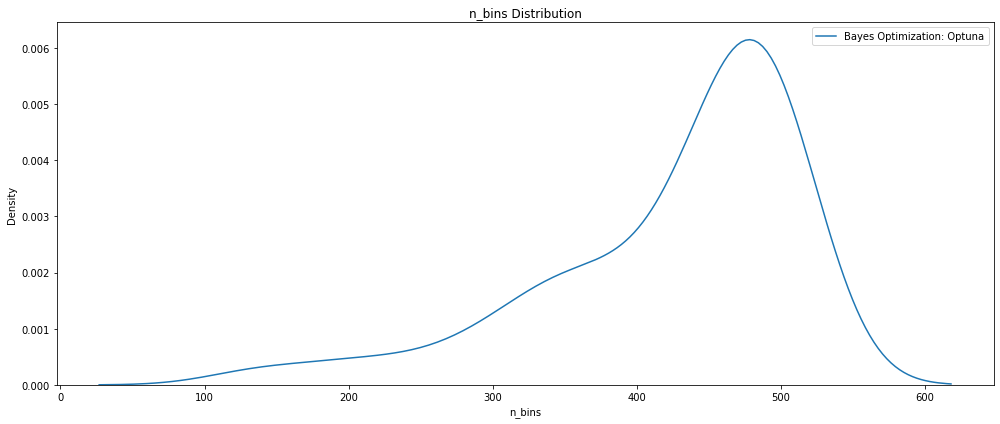

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'datetime_start', 'datetime_complete',
                   'duration','n_estimators', 'state']:
        plt.figure(figsize=(14,6))
        # Plot the random search distribution and the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label='Bayes Optimization: Optuna')
            plt.legend(loc = 0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

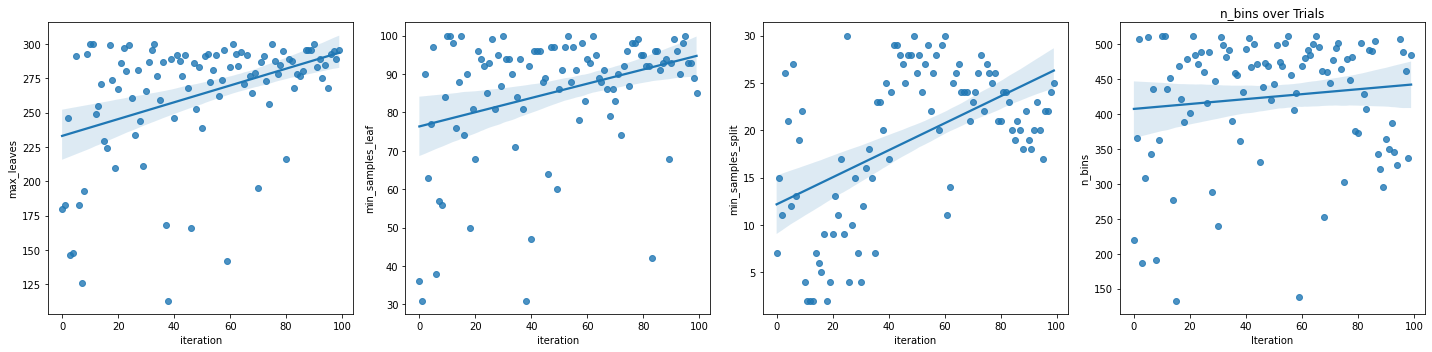

In [ ]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(1, 4, figsize=(20,5))
i = 0
axs = axs.flatten()
for i, hpo in enumerate(['max_leaves', 'min_samples_leaf', 'min_samples_split',
                         'n_bins']): 
                         # Scatterplot
                         sns.regplot('iteration', hpo, data=trials_df, ax=axs[i]) 
                         axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo),  
                                    title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/RF/Optuna/TrainTest/Model_Explanations/

/content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_Explanations


In [ ]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_RF_Optuna_US_100_GPU_ROCweighted.html')
fig.show()

In [ ]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_RF_Optuna_US_100_GPU_ROCweighted.html')
fig.show()

In [ ]:
# Arrange best parameters to fit model for model metrics
params = study.best_params   
params['random_state'] = seed_value
params

{'max_depth': 26,
 'max_leaves': 277,
 'min_samples_leaf': 86,
 'min_samples_split': 24,
 'n_bins': 462,
 'n_estimators': 469,
 'random_state': 42}

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/RF/Optuna/TrainTest/Model_PKL/

/content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_PKL


In [ ]:
# Set up train/test split
X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')
X_train = X_train.astype('float32')

X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')
X_test = X_test.astype('float32')

In [ ]:
# Re-create the best model and train on the training data
best_model = RandomForestClassifier(n_streams=1, 
                                    **params)

# Fit the model
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'RF_Optuna_US_trials100_GPU_ROCweighted.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('RF_Optuna_US_trials100_GPU_ROCweighted.pkl')
# print(model)
# =============================================================================

In [ ]:
print('\nModel Metrics for RF HPO Upsampling 100trials GPU ROCweighted')
# Predict based on training 
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

print('\n')
print('Classification Report:')
clf_rpt = classification_report(asnumpy(y_test), asnumpy(y_test_pred))
print(clf_rpt)
print('\n')
print('Confusion matrix:')
print(confusion_matrix(asnumpy(y_test), asnumpy(y_test_pred)))
print('\n')
print('Accuracy score : %.3f' % accuracy_score(asnumpy(y_test), 
                                               asnumpy(y_test_pred)))
print('Precision score : %.3f' % precision_score(asnumpy(y_test), 
                                                 asnumpy(y_test_pred)))
print('Recall score : %.3f' % recall_score(asnumpy(y_test), 
                                           asnumpy(y_test_pred)))
print('F1 score : %.3f' % f1_score(asnumpy(y_test), asnumpy(y_test_pred)))


Model Metrics for RF HPO Upsampling 100trials GPU ROCweighted


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98    377848
           1       0.79      0.91      0.84     54625

    accuracy                           0.96    432473
   macro avg       0.89      0.94      0.91    432473
weighted avg       0.96      0.96      0.96    432473



Confusion matrix:
[[364335  13513]
 [  5058  49567]]


Accuracy score : 0.957
Precision score : 0.786
Recall score : 0.907
F1 score : 0.842


In [ ]:
# Evaluate on the testing data 
print('The best model from Upsampling 100 ROCweighted GPU trials optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(asnumpy(y_test), 
                                                                                                                                           asnumpy(y_test_pred))))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from Upsampling 100 ROCweighted GPU trials optimization scores 0.93582 AUC ROC on the test set.
This was achieved using these conditions:
iteration                                    67
roc_weighted                           0.935821
datetime_start       2022-06-10 19:29:55.956892
datetime_complete    2022-06-10 19:32:07.134769
duration                 0 days 00:02:11.177877
max_depth                                    26
max_leaves                                  277
min_samples_leaf                             86
min_samples_split                            24
n_bins                                      462
n_estimators                                469
state                                  COMPLETE
Name: 67, dtype: object


### 300 Trials

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/RF/Optuna/TrainTest/Model_PKL

# Define a name for the trials
study_name = 'dask_rf_optuna_US_300_weightedROC_tpe'

/content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_PKL


In [ ]:
# Define objective function with the parameters to be tested
def objective(trial, X_param, y_param):

    joblib.dump(study, 'RF_Optuna_US_300_GPU_ROCweighted.pkl')

    # Search parameters
    n_estimators = trial.suggest_int('n_estimators', 200, 700) 
    max_depth = trial.suggest_int('max_depth', 15, 50) 
    max_leaves = trial.suggest_int('max_leaves', 200, 500) 
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 30, 150)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 30) 
    n_bins = trial.suggest_int('n_bins', 128, 512)
    
    score = train_and_eval(X_param,
                           y_param,
                           bootstrap=True, 
                           n_estimators=n_estimators,
                           max_depth=max_depth,
                           max_leaves=max_leaves, 
                           min_samples_leaf=min_samples_leaf,
                           min_samples_split=min_samples_split, 
                           n_bins=n_bins)

    return score

In [ ]:
with timed('dask_optuna'):
    # Begin HPO trials 
    # Start timer for experiment
    start_time = datetime.now()
    print('%-20s %s' % ('Start Time', start_time))
    if os.path.isfile('RF_Optuna_US_300_GPU_ROCweighted.pkl'): 
      study = joblib.load('RF_Optuna_US_300_GPU_ROCweighted.pkl')
    else: 
      study = optuna.create_study(sampler=optuna.samplers.TPESampler(), 
                                  study_name=study_name,
                                  direction='maximize')
      
    # Optimize in parallel on Dask cluster
    with parallel_backend('dask'):
        study.optimize(lambda trial: objective(trial, X_train, y_train), 
                       n_trials=300,
                       n_jobs=n_workers)

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Highest ROCweighted score', study.best_value)

Start Time           2022-06-11 16:42:04.896288
- Trial time: 190.97772544999998
- Trial weighted ROC: 0.9404541321012112
######################################################
- Trial time: 182.37625765100006
- Trial weighted ROC: 0.9403120948178791
######################################################
- Trial time: 187.64877852600011
- Trial weighted ROC: 0.9388347475892258
######################################################
- Trial time: 187.2146733100003
- Trial weighted ROC: 0.9400677114626312
######################################################
- Trial time: 76.3820388410004
- Trial weighted ROC: 0.9395318986284218
######################################################
- Trial time: 190.97816217599984
- Trial weighted ROC: 0.9399822463691404
######################################################
- Trial time: 195.744523672
- Trial weighted ROC: 0.9401610138824484
######################################################
- Trial time: 181.3080848300001
- Trial weighted ROC: 0.9

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/RF/Optuna/TrainTest/trialOptions/

/content/drive/MyDrive/LoanStatus/ML/RF/Optuna/trialOptions


In [ ]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number':'iteration'}, inplace=True)
trials_df.rename(columns={'value':'roc_weighted'},inplace=True)
trials_df.rename(columns={'params_max_depth':'max_depth'}, inplace=True)
trials_df.rename(columns={'params_max_leaves':'max_leaves'}, inplace=True)
trials_df.rename(columns={'params_min_samples_leaf':'min_samples_leaf'}, 
                 inplace=True)
trials_df.rename(columns={'params_min_samples_split':'min_samples_split'}, 
                 inplace=True)
trials_df.rename(columns={'params_n_bins':'n_bins'}, inplace=True)
trials_df.rename(columns={'params_n_estimators':'n_estimators'}, inplace=True)

# Write processed data to csv
trials_df = trials_df.sort_values('roc_weighted', ascending=False)
trials_df.to_csv('RF_Optuna_US_300_GPU_ROCweighted.csv', index=False)
print(trials_df) 

     iteration  roc_weighted             datetime_start  \
277        277      0.940887 2022-06-11 18:17:58.857482   
168        168      0.940870 2022-06-11 05:00:00.092729   
297        297      0.940803 2022-06-11 19:19:04.429338   
64          64      0.940790 2022-06-11 00:09:23.483357   
137        137      0.940716 2022-06-11 03:29:35.297031   
..         ...           ...                        ...   
6            6      0.932326 2022-06-10 22:09:02.585623   
290        290      0.932185 2022-06-11 18:57:51.517744   
39          39      0.931274 2022-06-10 23:17:09.277612   
1            1      0.931139 2022-06-10 21:58:52.257279   
243        243           NaN 2022-06-11 08:55:29.181880   

             datetime_complete               duration  max_depth  max_leaves  \
277 2022-06-11 18:21:07.951160 0 days 00:03:09.093678       37.0       492.0   
168 2022-06-11 05:03:15.599613 0 days 00:03:15.506884       39.0       500.0   
297 2022-06-11 19:21:48.330092 0 days 00:02:43.9007

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/RF/Optuna/TrainTest/Model_Explanations/

/content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_Explanations


In [ ]:
# Plot_optimization_history: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_RF_Optuna_US_300_GPU_ROCweighted.html')
fig.show()

In [ ]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_RF_Optuna_US_300_GPU_ROCweighted.html')
fig.show()

In [ ]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_RF_Optuna_US_300_GPU_ROCweighted.html')
fig.show()

In [ ]:
# plot_contour: plots parameter interactions on an interactive chart. 
fig = optuna.visualization.plot_contour(study, params=['max_leaves', 
                                                       'min_samples_leaf',
                                                       'max_depth', 
                                                       'min_samples_split'])
py.plot(fig, filename='contour_RF_Optuna_US_300_GPU_ROCweighted.html')
fig.show()

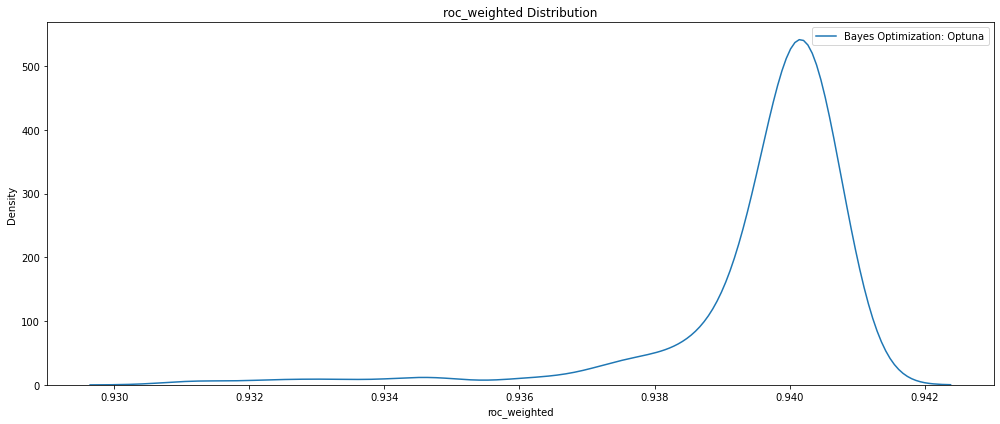

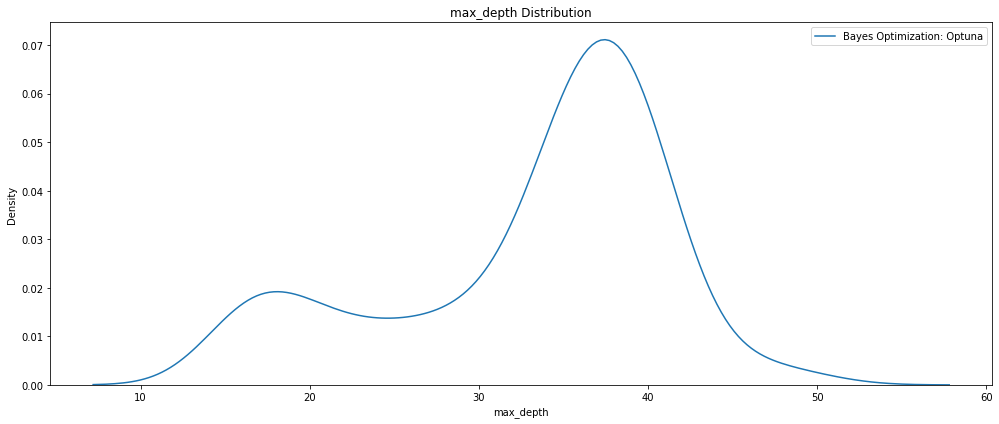

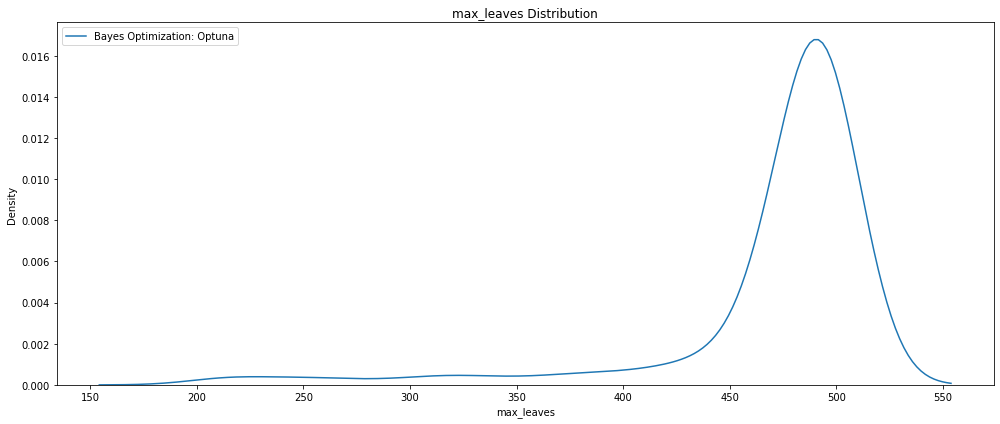

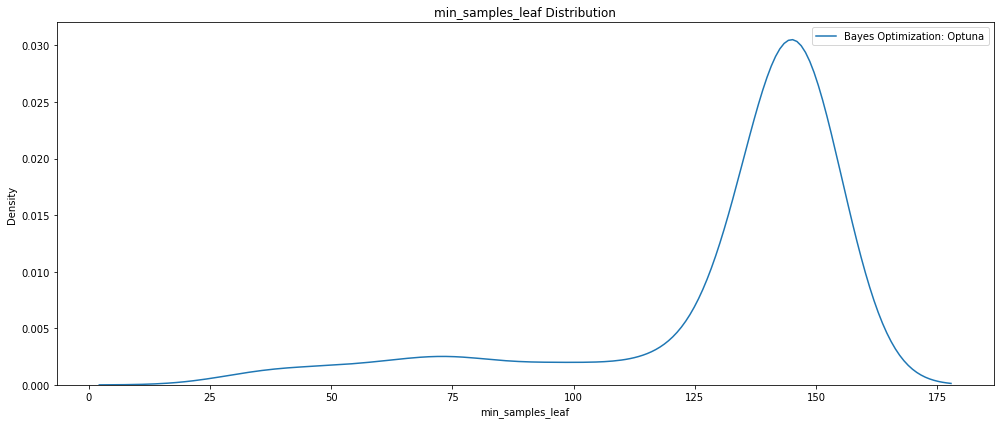

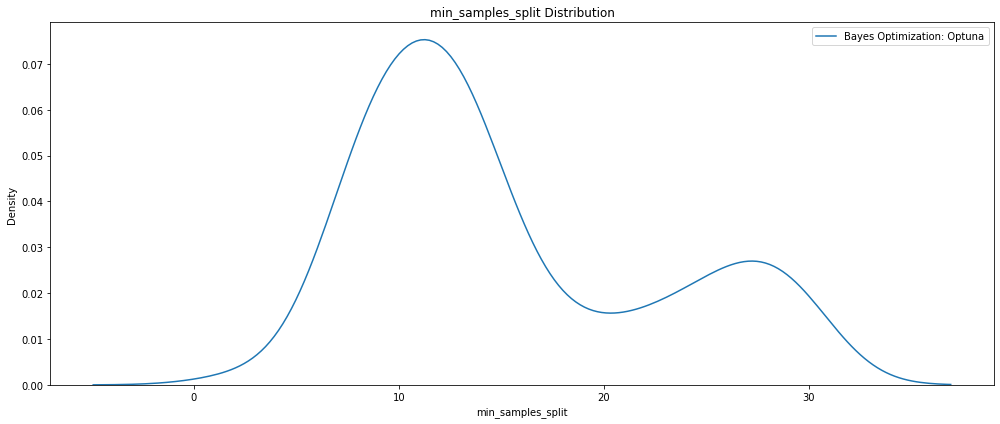

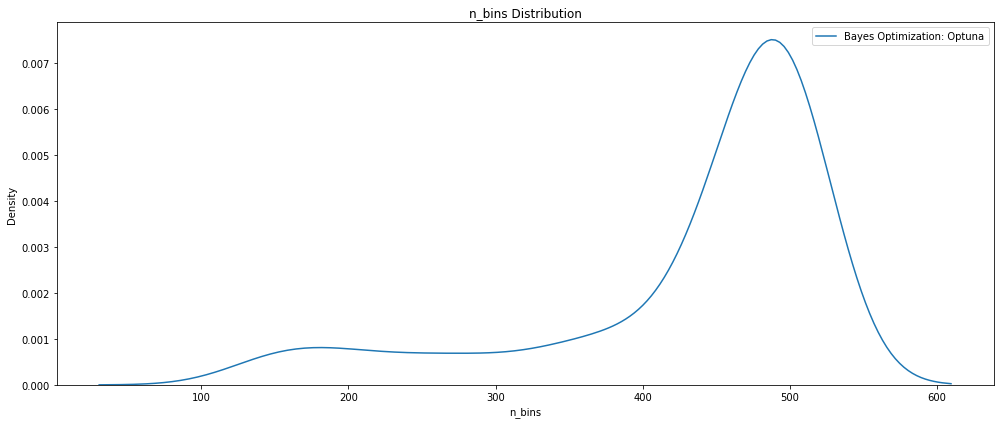

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'datetime_start', 'datetime_complete',
                   'duration','n_estimators', 'state']:
        plt.figure(figsize=(14,6))
        # Plot the random search distribution and the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label='Bayes Optimization: Optuna')
            plt.legend(loc = 0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

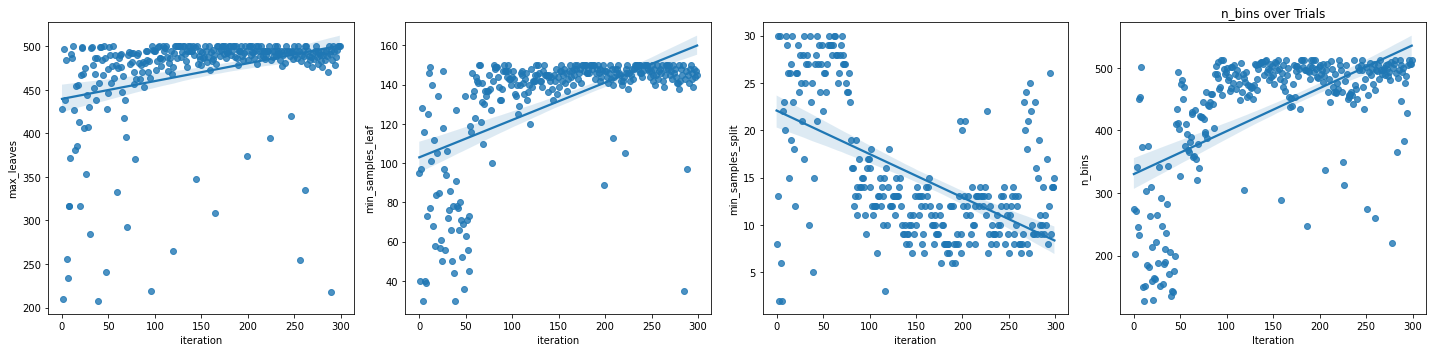

In [ ]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(1, 4, figsize=(20,5))
i = 0
axs = axs.flatten()
for i, hpo in enumerate(['max_leaves', 'min_samples_leaf', 'min_samples_split',
                         'n_bins']): 
                         # Scatterplot
                         sns.regplot('iteration', hpo, data=trials_df, ax=axs[i]) 
                         axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo),  
                                    title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

In [ ]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_RF_Optuna_US_300_GPU_ROCweighted.html')
fig.show()

In [ ]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_RF_Optuna_US_300_GPU_ROCweighted.html')
fig.show()

In [ ]:
# Arrange best parameters to fit model for model metrics
params = study.best_params   
params['random_state'] = seed_value
params

{'max_depth': 37,
 'max_leaves': 492,
 'min_samples_leaf': 141,
 'min_samples_split': 9,
 'n_bins': 510,
 'n_estimators': 646,
 'random_state': 42}

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/RF/Optuna/TrainTest/Model_PKL/

/content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_PKL


In [ ]:
# Set up train/test split
X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')
X_train = X_train.astype('float32')

X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')
X_test = X_test.astype('float32')

In [ ]:
# Re-create the best model and train on the training data
best_model = RandomForestClassifier(n_streams=1, 
                                    **params)

# Fit the model
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'RF_Optuna_US_trials300_GPU_ROCweighted.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('RF_Optuna_US_trials300_GPU_ROCweighted.pkl')
# print(model)
# =============================================================================

In [ ]:
print('\nModel Metrics for RF HPO Upsampling 300trials GPU ROCweighted')
# Predict based on training 
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

print('\n')
print('Classification Report:')
clf_rpt = classification_report(asnumpy(y_test), asnumpy(y_test_pred))
print(clf_rpt)
print('\n')
print('Confusion matrix:')
print(confusion_matrix(asnumpy(y_test), asnumpy(y_test_pred)))
print('\n')
print('Accuracy score : %.3f' % accuracy_score(asnumpy(y_test), 
                                               asnumpy(y_test_pred)))
print('Precision score : %.3f' % precision_score(asnumpy(y_test), 
                                                 asnumpy(y_test_pred)))
print('Recall score : %.3f' % recall_score(asnumpy(y_test), 
                                           asnumpy(y_test_pred)))
print('F1 score : %.3f' % f1_score(asnumpy(y_test), asnumpy(y_test_pred)))


Model Metrics for RF HPO Upsampling 300trials GPU ROCweighted


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98    377848
           1       0.82      0.91      0.86     54625

    accuracy                           0.96    432473
   macro avg       0.90      0.94      0.92    432473
weighted avg       0.97      0.96      0.96    432473



Confusion matrix:
[[367105  10743]
 [  4905  49720]]


Accuracy score : 0.964
Precision score : 0.822
Recall score : 0.910
F1 score : 0.864


In [ ]:
# Evaluate on the testing data 
print('The best model from Upsampling 300 ROCweighted GPU trials optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(asnumpy(y_test), 
                                                                                                                                           asnumpy(y_test_pred))))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from Upsampling 300 ROCweighted GPU trials optimization scores 0.94089 AUC ROC on the test set.
This was achieved using these conditions:
iteration                                   277
roc_weighted                           0.940887
datetime_start       2022-06-11 18:17:58.857482
datetime_complete    2022-06-11 18:21:07.951160
duration                 0 days 00:03:09.093678
max_depth                                  37.0
max_leaves                                492.0
min_samples_leaf                          141.0
min_samples_split                           9.0
n_bins                                    510.0
n_estimators                              646.0
state                                  COMPLETE
Name: 277, dtype: object


## Recall

### 100 Trials

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/RF/Optuna/TrainTest/Model_PKL

# Define a name for the trials
study_name = 'dask_rf_optuna_US_100_Recall_tpe'

/content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_PKL


In [ ]:
# Define function to train/evaluate the model
def train_and_eval(X_param, y_param, bootstrap=True,  
                   n_estimators=100, max_depth=16, 
                   max_leaves=100, min_samples_leaf=30, 
                   min_samples_split=10, n_bins=128): 
    """
        Partition data into train/test sets, train and evaluate the model
        for the given parameters.
        
        Params
        ______
        
        X_param:  DataFrame. 
                  The data to use for training and testing. 
        y_param:  Series. 
                  The label for training

        Returns
        score: Recall score of the fitted model
    """
    
    X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')
    X_train = X_train.astype('float32')

    X_test, y_test = testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')
    X_test = X_test.astype('float32')

    model = RandomForestClassifier(random_state=seed_value, n_streams=1, 
                                   bootstrap=bootstrap, 
                                   n_estimators=n_estimators,
                                   max_depth=max_depth,
                                   max_leaves=max_leaves, 
                                   min_samples_leaf=min_samples_leaf,
                                   min_samples_split=min_samples_split, 
                                   n_bins=n_bins)
    
    # Start timer for each trial
    start = timer()

    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    score = recall_score(asnumpy(y_test), asnumpy(y_pred))
     
    run_time = timer() - start

    print('- Trial time:', run_time) 
    print('- Trial recall score:', score)
    print('######################################################')

    return score

In [ ]:
print('Score with default parameters : ', train_and_eval(X_train, y_train))

- Trial time: 25.492539251999915
- Trial recall score: 0.8865171624713959
######################################################
Score with default parameters :  0.8865171624713959


In [ ]:
# Define objective function with the parameters to be tested
def objective(trial, X_param, y_param):

    joblib.dump(study, 'RF_Optuna_US_100_GPU_Recall.pkl')

    # Search parameters
    n_estimators = trial.suggest_int('n_estimators', 100, 500) 
    max_depth = trial.suggest_int('max_depth', 16, 30) 
    max_leaves = trial.suggest_int('max_leaves', 100, 300) 
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 30, 100)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 30) 
    n_bins = trial.suggest_int('n_bins', 128, 512)
    
    score = train_and_eval(X_param,
                           y_param,
                           bootstrap=True, 
                           n_estimators=n_estimators,
                           max_depth=max_depth,
                           max_leaves=max_leaves, 
                           min_samples_leaf=min_samples_leaf,
                           min_samples_split=min_samples_split, 
                           n_bins=n_bins)

    return score

In [ ]:
with timed('dask_optuna'):
    # Begin HPO trials 
    # Start timer for experiment
    start_time = datetime.now()
    print('%-20s %s' % ('Start Time', start_time))
    if os.path.isfile('RF_Optuna_US_100_GPU_Recall.pkl'): 
      study = joblib.load('RF_Optuna_US_100_GPU_Recall.pkl')
    else: 
      study = optuna.create_study(sampler=optuna.samplers.TPESampler(), 
                                  study_name=study_name,
                                  direction='maximize')
      
    # Optimize in parallel on Dask cluster
    with parallel_backend('dask'):
        study.optimize(lambda trial: objective(trial, X_train, y_train), 
                       n_trials=100,
                       n_jobs=n_workers)

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Highest Recall score', study.best_value)

Start Time           2022-06-11 20:14:13.635818
- Trial time: 69.03230393400008
- Trial recall score: 0.9068924485125858
######################################################
- Trial time: 104.16208702400036
- Trial recall score: 0.8949199084668192
######################################################
- Trial time: 90.07661657999961
- Trial recall score: 0.9069839816933638
######################################################
- Trial time: 91.37567860499985
- Trial recall score: 0.905446224256293
######################################################
- Trial time: 111.68017649000103
- Trial recall score: 0.9073318077803204
######################################################
- Trial time: 41.441167741000754
- Trial recall score: 0.9075514874141877
######################################################
- Trial time: 119.16414562199861
- Trial recall score: 0.9058855835240275
######################################################
- Trial time: 55.02275012999962
- Trial recall score:

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/RF/Optuna/TrainTest/trialOptions/

/content/drive/MyDrive/LoanStatus/ML/RF/Optuna/trialOptions


In [ ]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number':'iteration'}, inplace=True)
trials_df.rename(columns={'value':'recall'},inplace=True)
trials_df.rename(columns={'params_max_depth':'max_depth'}, inplace=True)
trials_df.rename(columns={'params_max_leaves':'max_leaves'}, inplace=True)
trials_df.rename(columns={'params_min_samples_leaf':'min_samples_leaf'}, 
                 inplace=True)
trials_df.rename(columns={'params_min_samples_split':'min_samples_split'},
                 inplace=True)
trials_df.rename(columns={'params_n_bins':'n_bins'}, inplace=True)
trials_df.rename(columns={'params_n_estimators':'n_estimators'}, inplace=True)

# Write processed data to csv
trials_df = trials_df.sort_values('recall', ascending=False)
trials_df.to_csv('RF_Optuna_US_100_GPU_Recall.csv', index=False)
print(trials_df) 

    iteration    recall             datetime_start          datetime_complete  \
64         64  0.909162 2022-06-11 21:44:04.395382 2022-06-11 21:45:34.170904   
36         36  0.908870 2022-06-11 21:04:56.797358 2022-06-11 21:06:16.375919   
45         45  0.908668 2022-06-11 21:17:21.400593 2022-06-11 21:18:54.216490   
71         71  0.908485 2022-06-11 21:53:32.305237 2022-06-11 21:54:53.315953   
89         89  0.908430 2022-06-11 22:17:52.932229 2022-06-11 22:19:16.632580   
..        ...       ...                        ...                        ...   
27         27  0.901199 2022-06-11 20:53:31.835232 2022-06-11 20:54:00.085291   
26         26  0.900265 2022-06-11 20:51:58.124049 2022-06-11 20:53:31.835105   
9           9  0.898288 2022-06-11 20:26:54.135132 2022-06-11 20:27:33.443264   
59         59  0.897446 2022-06-11 21:36:49.218728 2022-06-11 21:38:18.878387   
1           1  0.894920 2022-06-11 20:15:22.821308 2022-06-11 20:17:07.129569   

                 duration  

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/RF/Optuna/TrainTest/Model_Explanations/

/content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_Explanations


In [ ]:
# Plot_optimization_history: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_RF_Optuna_US_100_GPU_Recall.html')
fig.show()

In [ ]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_RF_Optuna_US_100_GPU_Recall.html')
fig.show()

In [ ]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_RF_Optuna_US_100_GPU_Recall.html')
fig.show()

In [ ]:
# plot_contour: plots parameter interactions on an interactive chart. 
fig = optuna.visualization.plot_contour(study, params=['max_leaves', 
                                                       'min_samples_leaf',
                                                       'max_depth', 
                                                       'min_samples_split'])
py.plot(fig, filename='contour_RF_Optuna_US_100_GPU_Recall.html')
fig.show()

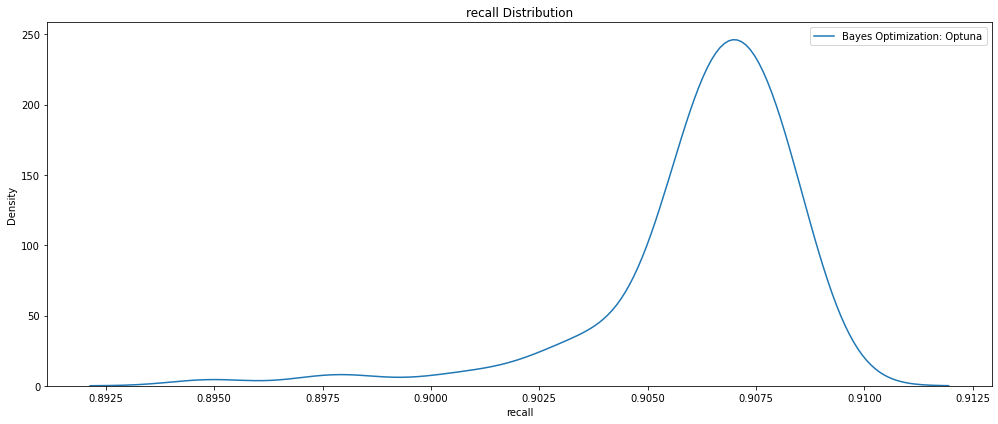

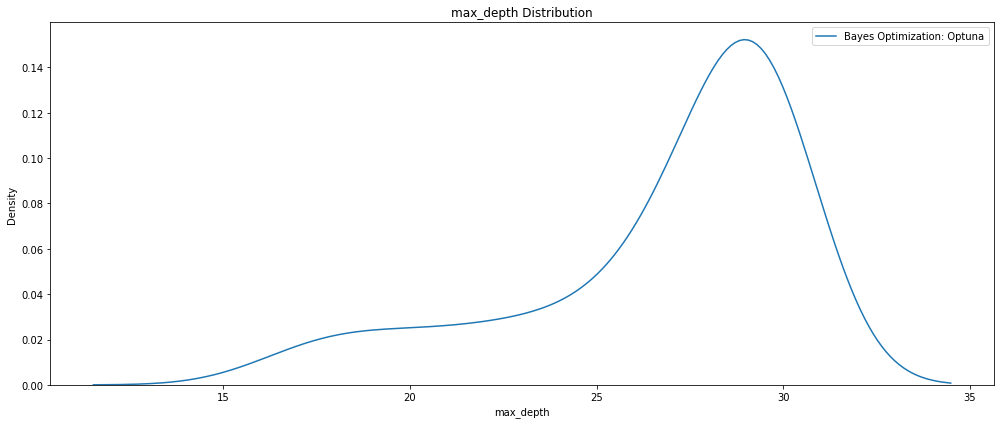

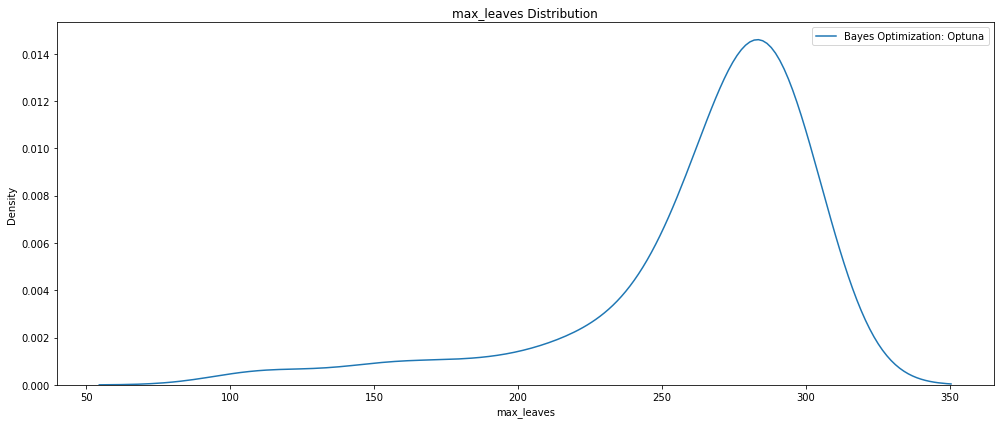

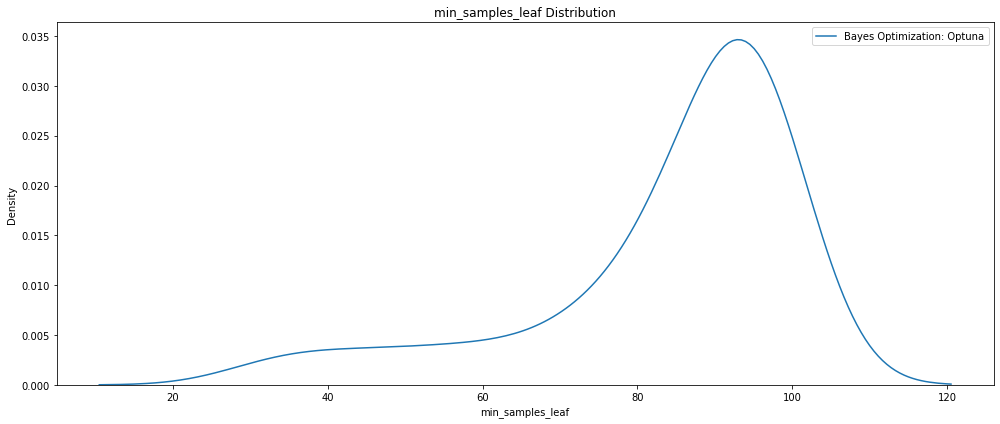

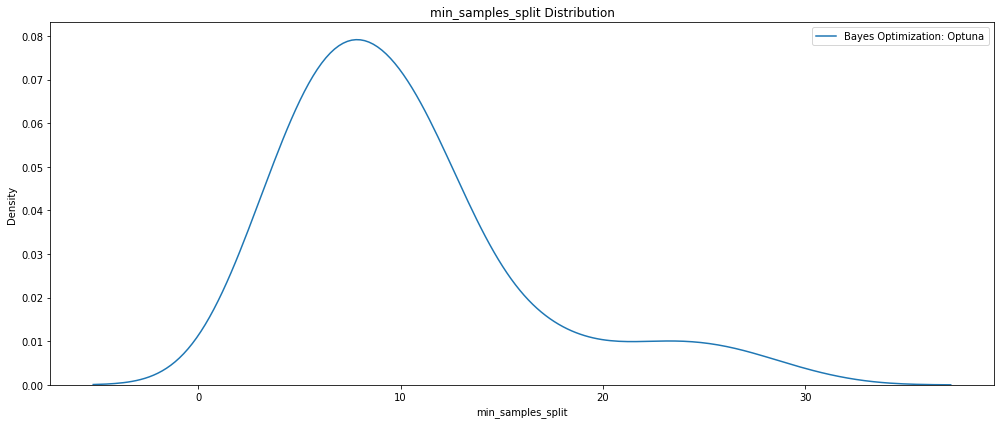

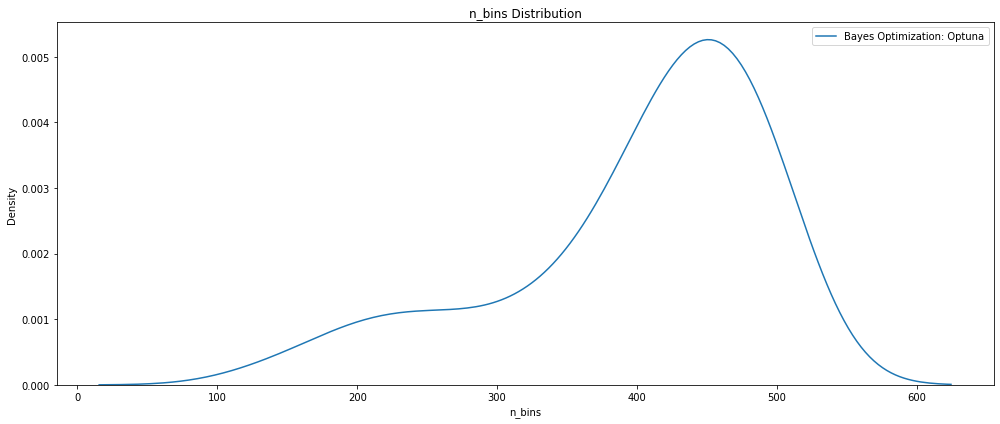

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'datetime_start', 'datetime_complete',
                   'duration','n_estimators', 'state']:
        plt.figure(figsize=(14,6))
        # Plot the random search distribution and the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label='Bayes Optimization: Optuna')
            plt.legend(loc = 0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

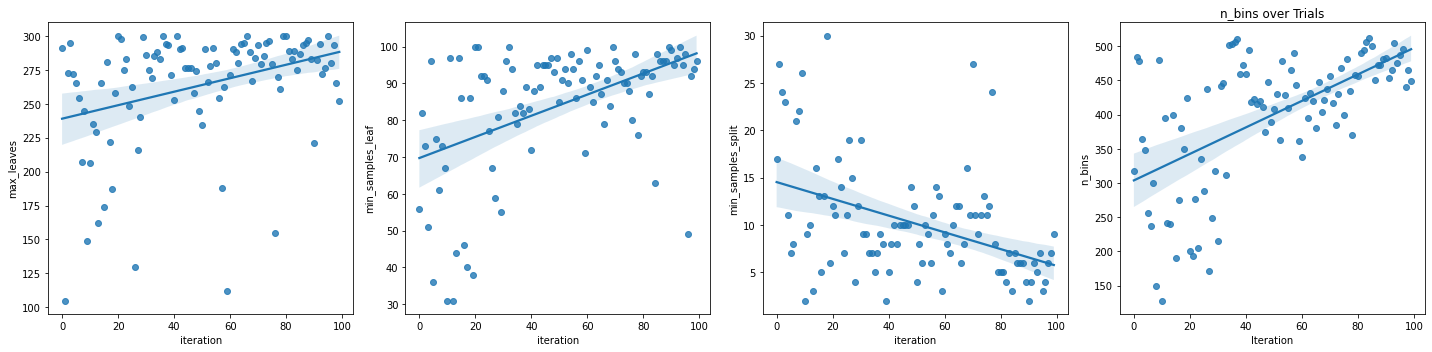

In [ ]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(1, 4, figsize=(20,5))
i = 0
axs = axs.flatten()
for i, hpo in enumerate(['max_leaves', 'min_samples_leaf', 'min_samples_split',
                         'n_bins']): 
                         # Scatterplot
                         sns.regplot('iteration', hpo, data=trials_df, ax=axs[i]) 
                         axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo),  
                                    title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

In [ ]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_RF_Optuna_US_100_GPU_Recall.html')
fig.show()

In [ ]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_RF_Optuna_US_100_GPU_Recall.html')
fig.show()

In [ ]:
# Arrange best parameters to fit model for model metrics
params = study.best_params   
params['random_state'] = seed_value
params

{'max_depth': 30,
 'max_leaves': 294,
 'min_samples_leaf': 95,
 'min_samples_split': 12,
 'n_bins': 420,
 'n_estimators': 318,
 'random_state': 42}

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/RF/Optuna/TrainTest/Model_PKL/

/content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_PKL


In [ ]:
# Set up train/test split
X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')
X_train = X_train.astype('float32')

X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')
X_test = X_test.astype('float32')

In [ ]:
# Re-create the best model and train on the training data
best_model = RandomForestClassifier(n_streams=1, 
                                    **params)

# Fit the model
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'RF_Optuna_US_trials100_GPU_Recall.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('RF_Optuna_US_trials100_GPU_ROCweighted.pkl')
# print(model)
# =============================================================================

In [ ]:
print('\nModel Metrics for RF HPO US 100trials GPU Recall')
# Predict based on training 
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

print('\n')
print('Classification Report:')
clf_rpt = classification_report(asnumpy(y_test), asnumpy(y_test_pred))
print(clf_rpt)
print('\n')
print('Confusion matrix:')
print(confusion_matrix(asnumpy(y_test), asnumpy(y_test_pred)))
print('\n')
print('Accuracy score : %.3f' % accuracy_score(asnumpy(y_test), 
                                               asnumpy(y_test_pred)))
print('Precision score : %.3f' % precision_score(asnumpy(y_test), 
                                                 asnumpy(y_test_pred)))
print('Recall score : %.3f' % recall_score(asnumpy(y_test), 
                                           asnumpy(y_test_pred)))
print('F1 score : %.3f' % f1_score(asnumpy(y_test), asnumpy(y_test_pred)))


Model Metrics for RF HPO US 100trials GPU Recall


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97    377848
           1       0.77      0.91      0.83     54625

    accuracy                           0.95    432473
   macro avg       0.88      0.93      0.90    432473
weighted avg       0.96      0.95      0.96    432473



Confusion matrix:
[[362942  14906]
 [  4962  49663]]


Accuracy score : 0.954
Precision score : 0.769
Recall score : 0.909
F1 score : 0.833


In [ ]:
# Evaluate on the testing data 
print('The best model from US 100 Recall GPU trials optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(asnumpy(y_test), 
                                                                                                                              asnumpy(y_test_pred))))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from US 100 Recall GPU trials optimization scores 0.93486 AUC ROC on the test set.
This was achieved using these conditions:
iteration                                    64
recall                                 0.909162
datetime_start       2022-06-11 21:44:04.395382
datetime_complete    2022-06-11 21:45:34.170904
duration                 0 days 00:01:29.775522
max_depth                                    30
max_leaves                                  294
min_samples_leaf                             95
min_samples_split                            12
n_bins                                      420
n_estimators                                318
state                                  COMPLETE
Name: 64, dtype: object


### 300 Trials

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/RF/Optuna/TrainTest/Model_PKL

# Define a name for the trials
study_name = 'dask_rf_optuna_US_300_Recall_tpe'

/content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_PKL


In [ ]:
# Define objective function with the parameters to be tested
def objective(trial, X_param, y_param):

    joblib.dump(study, 'RF_Optuna_US_300_GPU_Recall.pkl')

    # Search parameters
    n_estimators = trial.suggest_int('n_estimators', 250, 500) 
    max_depth = trial.suggest_int('max_depth', 25, 50) 
    max_leaves = trial.suggest_int('max_leaves', 250, 500) 
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 80, 150)
    min_samples_split = trial.suggest_int('min_samples_split', 5, 20) 
    n_bins = trial.suggest_int('n_bins', 400, 700)
    
    score = train_and_eval(X_param,
                           y_param,
                           bootstrap=True, 
                           n_estimators=n_estimators,
                           max_depth=max_depth,
                           max_leaves=max_leaves, 
                           min_samples_leaf=min_samples_leaf,
                           min_samples_split=min_samples_split, 
                           n_bins=n_bins)

    return score

In [ ]:
with timed('dask_optuna'):
    # Begin HPO trials 
    # Start timer for experiment
    start_time = datetime.now()
    print('%-20s %s' % ('Start Time', start_time))
    if os.path.isfile('RF_Optuna_US_300_GPU_Recall.pkl'): 
      study = joblib.load('RF_Optuna_US_300_GPU_Recall.pkl')
    else: 
      study = optuna.create_study(sampler=optuna.samplers.TPESampler(), 
                                  study_name=study_name,
                                  direction='maximize')
      
    # Optimize in parallel on Dask cluster
    with parallel_backend('dask'):
        study.optimize(lambda trial: objective(trial, X_train, y_train), 
                       n_trials=300,
                       n_jobs=n_workers)

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Highest Recall score', study.best_value)

Start Time           2022-06-11 23:06:00.328982
- Trial time: 94.32594172400059
- Trial recall score: 0.9080091533180779
######################################################
- Trial time: 81.27362552200066
- Trial recall score: 0.9077162471395881
######################################################
- Trial time: 128.6280004879991
- Trial recall score: 0.9074233409610984
######################################################
- Trial time: 138.65542217799884
- Trial recall score: 0.909949656750572
######################################################
- Trial time: 93.30558563299928
- Trial recall score: 0.9081372997711671
######################################################
- Trial time: 126.16436163799881
- Trial recall score: 0.9082471395881007
######################################################
- Trial time: 131.51316450599916
- Trial recall score: 0.9067826086956522
######################################################
- Trial time: 133.6212334410011
- Trial recall score: 

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/RF/Optuna/TrainTest/trialOptions/

/content/drive/MyDrive/LoanStatus/ML/RF/Optuna/trialOptions


In [ ]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number':'iteration'}, inplace=True)
trials_df.rename(columns={'value':'recall'},inplace=True)
trials_df.rename(columns={'params_max_depth':'max_depth'}, inplace=True)
trials_df.rename(columns={'params_max_leaves':'max_leaves'}, inplace=True)
trials_df.rename(columns={'params_min_samples_leaf':'min_samples_leaf'}, 
                 inplace=True)
trials_df.rename(columns={'params_min_samples_split':'min_samples_split'}, 
                 inplace=True)
trials_df.rename(columns={'params_n_bins':'n_bins'}, inplace=True)
trials_df.rename(columns={'params_n_estimators':'n_estimators'}, inplace=True)

# Write processed data to csv
trials_df = trials_df.sort_values('recall', ascending=False)
trials_df.to_csv('RF_Optuna_US_300_GPU_Recall.csv', index=False)
print(trials_df) 

     iteration    recall             datetime_start  \
183        183  0.912037 2022-06-12 05:59:49.940206   
26          26  0.912000 2022-06-11 23:55:31.026618   
273        273  0.911982 2022-06-12 09:41:49.833018   
123        123  0.911945 2022-06-12 03:36:46.829515   
227        227  0.911927 2022-06-12 07:48:39.184703   
..         ...       ...                        ...   
1            1  0.907716 2022-06-11 23:07:34.811825   
2            2  0.907423 2022-06-11 23:08:56.223646   
107        107  0.907149 2022-06-12 03:05:50.156244   
32          32  0.906856 2022-06-12 00:09:38.675249   
6            6  0.906783 2022-06-11 23:17:03.626036   

             datetime_complete               duration  max_depth  max_leaves  \
183 2022-06-12 06:02:18.936403 0 days 00:02:28.996197         48         500   
26  2022-06-11 23:57:59.108853 0 days 00:02:28.082235         33         495   
273 2022-06-12 09:44:12.613376 0 days 00:02:22.780358         27         496   
123 2022-06-12 03:3

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/RF/Optuna/TrainTest/Model_Explanations/

/content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_Explanations


In [ ]:
# Plot_optimization_history: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_RF_Optuna_US_300_GPU_Recall.html')
fig.show()

In [ ]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_RF_Optuna_US_300_GPU_Recall.html')
fig.show()

In [ ]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_RF_Optuna_US_300_GPU_Recall.html')
fig.show()

In [ ]:
# plot_contour: plots parameter interactions on an interactive chart. 
fig = optuna.visualization.plot_contour(study, params=['max_leaves', 
                                                       'min_samples_leaf',
                                                       'max_depth', 
                                                       'min_samples_split'])
py.plot(fig, filename='contour_RF_Optuna_US_300_GPU_Recall.html')
fig.show()

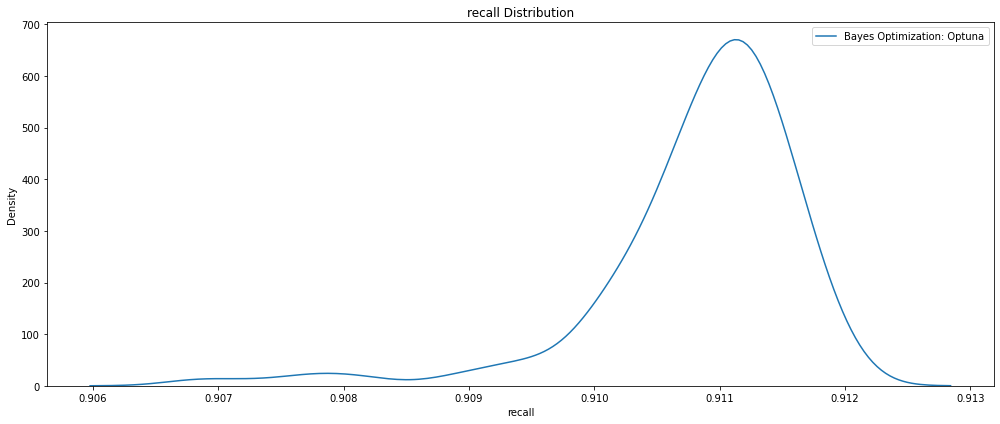

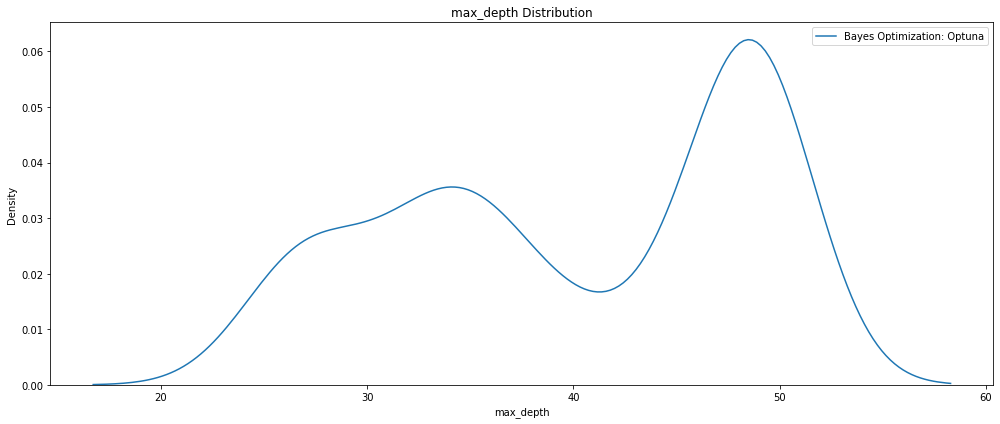

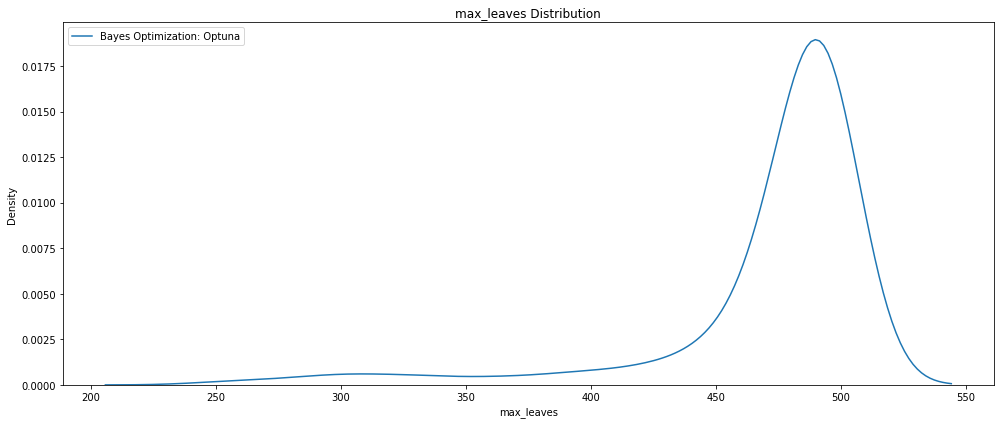

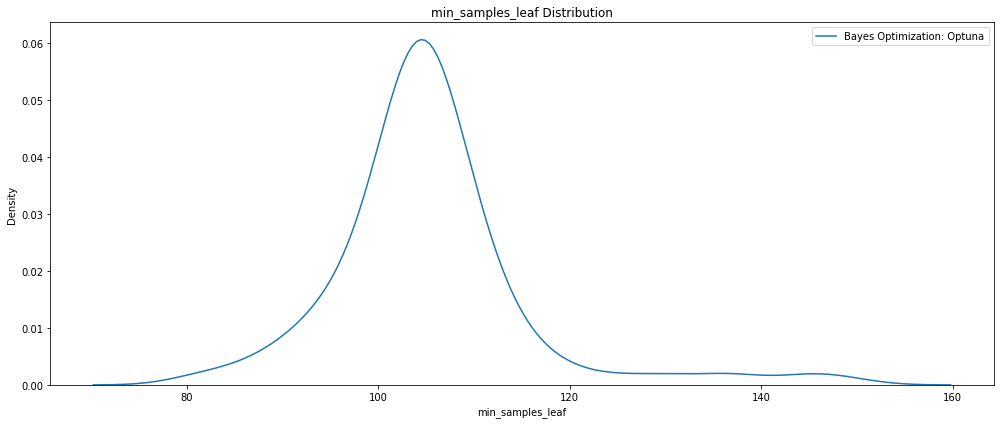

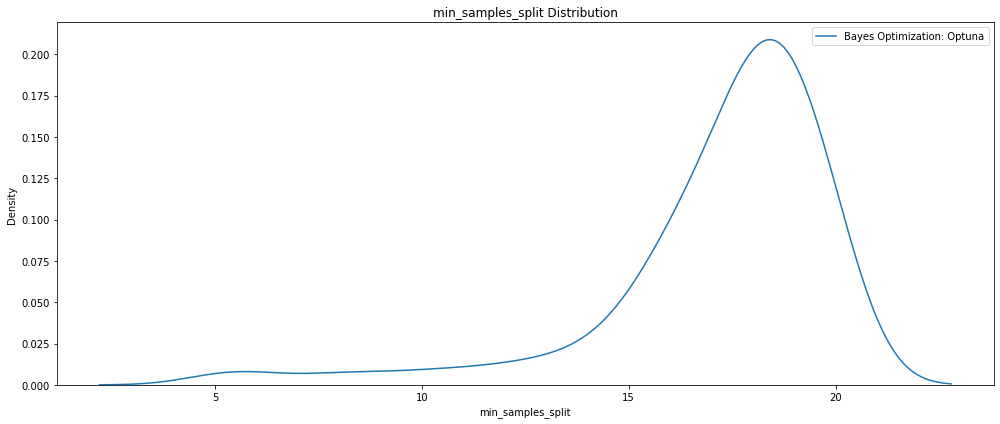

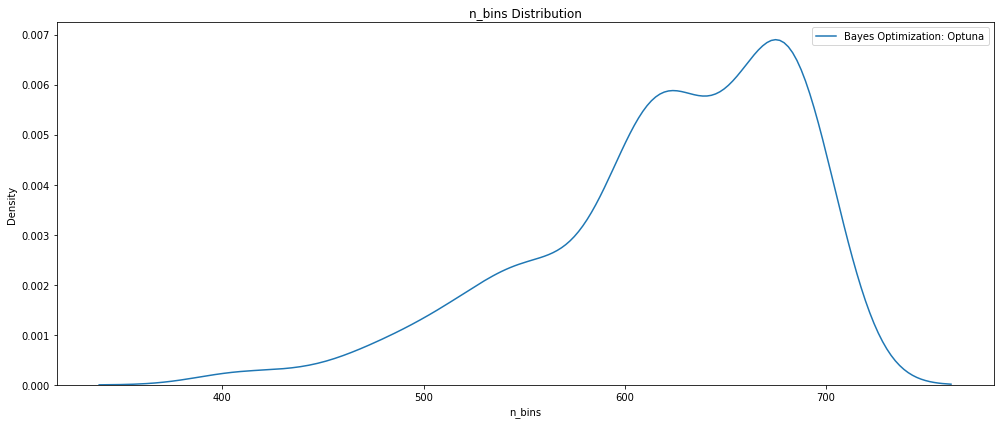

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'datetime_start', 'datetime_complete',
                   'duration','n_estimators', 'state']:
        plt.figure(figsize=(14,6))
        # Plot the random search distribution and the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label='Bayes Optimization: Optuna')
            plt.legend(loc = 0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

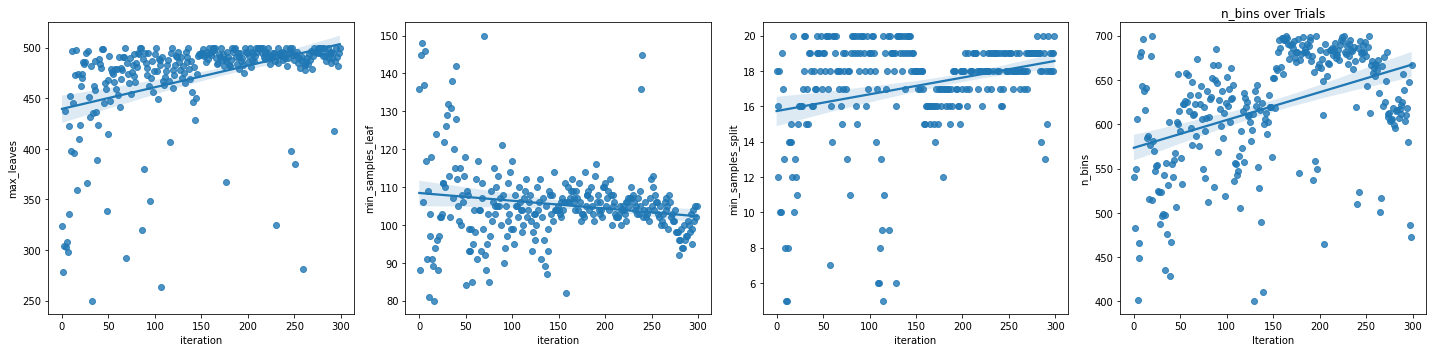

In [ ]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(1, 4, figsize=(20,5))
i = 0
axs = axs.flatten()
for i, hpo in enumerate(['max_leaves', 'min_samples_leaf', 'min_samples_split',
                         'n_bins']): 
                         # Scatterplot
                         sns.regplot('iteration', hpo, data=trials_df, ax=axs[i]) 
                         axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo),  
                                    title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

In [ ]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_RF_Optuna_US_300_GPU_Recall.html')
fig.show()

In [ ]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_RF_Optuna_US_300_GPU_Recall.html')
fig.show()

In [ ]:
# Arrange best parameters to fit model for model metrics
params = study.best_params   
params['random_state'] = seed_value
params

{'max_depth': 48,
 'max_leaves': 500,
 'min_samples_leaf': 104,
 'min_samples_split': 17,
 'n_bins': 682,
 'n_estimators': 495,
 'random_state': 42}

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/RF/Optuna/TrainTest/Model_PKL/

/content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_PKL


In [ ]:
# Set up train/test split
X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')
X_train = X_train.astype('float32')

X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')
X_test = X_test.astype('float32'

In [ ]:
# Re-create the best model and train on the training data
best_model = RandomForestClassifier(n_streams=1, 
                                    **params)

# Fit the model
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'RF_Optuna_US_trials300_GPU_Recall.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('RF_Optuna_US_trials300_GPU_ROCweighted.pkl')
# print(model)
# =============================================================================

In [ ]:
print('\nModel Metrics for RF HPO US 300trials GPU Recall')
# Predict based on training 
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

print('\n')
print('Classification Report:')
clf_rpt = classification_report(asnumpy(y_test), asnumpy(y_test_pred))
print(clf_rpt)
print('\n')
print('Confusion matrix:')
print(confusion_matrix(asnumpy(y_test), asnumpy(y_test_pred)))
print('\n')
print('Accuracy score : %.3f' % accuracy_score(asnumpy(y_test), 
                                               asnumpy(y_test_pred)))
print('Precision score : %.3f' % precision_score(asnumpy(y_test), 
                                                 asnumpy(y_test_pred)))
print('Recall score : %.3f' % recall_score(asnumpy(y_test), 
                                           asnumpy(y_test_pred)))
print('F1 score : %.3f' % f1_score(asnumpy(y_test), asnumpy(y_test_pred)))


Model Metrics for RF HPO US 300trials GPU Recall


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98    377848
           1       0.81      0.91      0.86     54625

    accuracy                           0.96    432473
   macro avg       0.90      0.94      0.92    432473
weighted avg       0.96      0.96      0.96    432473



Confusion matrix:
[[365902  11946]
 [  4805  49820]]


Accuracy score : 0.961
Precision score : 0.807
Recall score : 0.912
F1 score : 0.856


In [ ]:
# Evaluate on the testing data 
print('The best model from US 300 Recall GPU trials optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(asnumpy(y_test), 
                                                                                                                              asnumpy(y_test_pred))))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from US 300 Recall GPU trials optimization scores 0.94021 AUC ROC on the test set.
This was achieved using these conditions:
iteration                                   183
recall                                 0.912037
datetime_start       2022-06-12 05:59:49.940206
datetime_complete    2022-06-12 06:02:18.936403
duration                 0 days 00:02:28.996197
max_depth                                    48
max_leaves                                  500
min_samples_leaf                            104
min_samples_split                            17
n_bins                                      682
n_estimators                                495
state                                  COMPLETE
Name: 183, dtype: object


## Precision

### 100 Trials

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/RF/Optuna/TrainTest/Model_PKL

# Define a name for the trials
study_name = 'dask_rf_optuna_US_100_Precision_tpe'

/content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_PKL


In [ ]:
# Define function to train/evaluate the model
def train_and_eval(X_param, y_param, bootstrap=True,  
                   n_estimators=100, max_depth=16, 
                   max_leaves=100, min_samples_leaf=30, 
                   min_samples_split=10, n_bins=128): 
    """
        Partition data into train/test sets, train and evaluate the model
        for the given parameters.
        
        Params
        ______
        
        X_param:  DataFrame. 
                  The data to use for training and testing. 
        y_param:  Series. 
                  The label for training

        Returns
        score: Precision score of the fitted model
    """
    
    X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')
    X_train = X_train.astype('float32')

    X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')
    X_test = X_test.astype('float32')

    model = RandomForestClassifier(random_state=seed_value, n_streams=1, 
                                   bootstrap=bootstrap, 
                                   n_estimators=n_estimators,
                                   max_depth=max_depth,
                                   max_leaves=max_leaves, 
                                   min_samples_leaf=min_samples_leaf,
                                   min_samples_split=min_samples_split, 
                                   n_bins=n_bins)
    
    # Start timer for each trial
    start = timer()

    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    score = precision_score(asnumpy(y_test), asnumpy(y_pred))
     
    run_time = timer() - start

    print('- Trial time:', run_time) 
    print('- Trial precision score:', score)
    print('######################################################')

    return score

In [ ]:
print('Score with default parameters : ', train_and_eval(X_train, y_train))

- Trial time: 28.76669085399999
- Trial precision score: 0.7276742932438908
######################################################
Score with default parameters :  0.7276742932438908


In [ ]:
# Define objective function with the parameters to be tested
def objective(trial, X_param, y_param):

    joblib.dump(study, 'RF_Optuna_US_100_GPU_Precision.pkl')

    # Search parameters
    n_estimators = trial.suggest_int('n_estimators', 100, 500) 
    max_depth = trial.suggest_int('max_depth', 16, 30) 
    max_leaves = trial.suggest_int('max_leaves', 100, 300) 
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 30, 100)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 30) 
    n_bins = trial.suggest_int('n_bins', 128, 512)
    
    score = train_and_eval(X_param,
                           y_param,
                           bootstrap=True, 
                           n_estimators=n_estimators,
                           max_depth=max_depth,
                           max_leaves=max_leaves, 
                           min_samples_leaf=min_samples_leaf,
                           min_samples_split=min_samples_split, 
                           n_bins=n_bins)

    return score

In [ ]:
with timed('dask_optuna'):
    # Begin HPO trials 
    # Start timer for experiment
    start_time = datetime.now()
    print('%-20s %s' % ('Start Time', start_time))
    if os.path.isfile('RF_Optuna_US_100_GPU_Precision.pkl'): 
      study = joblib.load('RF_Optuna_US_100_GPU_Precision.pkl')
    else: 
      study = optuna.create_study(sampler=optuna.samplers.TPESampler(), 
                                  study_name=study_name,
                                  direction='maximize')
      
    # Optimize in parallel on Dask cluster
    with parallel_backend('dask'):
        study.optimize(lambda trial: objective(trial, X_train, y_train), 
                       n_trials=100,
                       n_jobs=n_workers)

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Highest Precision score', study.best_value)

Start Time           2022-06-14 13:47:25.302153
- Trial time: 61.972316589
- Trial precision score: 0.7833051075481553
######################################################
- Trial time: 82.79910408399996
- Trial precision score: 0.7240659324501169
######################################################
- Trial time: 95.9841732010002
- Trial precision score: 0.7658165313242968
######################################################
- Trial time: 114.76380436000022
- Trial precision score: 0.7471063849152774
######################################################
- Trial time: 60.687086162000014
- Trial precision score: 0.7217873163866655
######################################################
- Trial time: 109.39693960400018
- Trial precision score: 0.7550789722909602
######################################################
- Trial time: 141.10978471299995
- Trial precision score: 0.7703703703703704
######################################################
- Trial time: 69.85933940400037
- Tri

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/RF/Optuna/TrainTest/trialOptions/

/content/drive/MyDrive/LoanStatus/ML/RF/Optuna/trialOptions


In [ ]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number':'iteration'}, inplace=True)
trials_df.rename(columns={'value':'precision'},inplace=True)
trials_df.rename(columns={'params_max_depth':'max_depth'}, inplace=True)
trials_df.rename(columns={'params_max_leaves':'max_leaves'}, inplace=True)
trials_df.rename(columns={'params_min_samples_leaf':'min_samples_leaf'}, 
                 inplace=True)
trials_df.rename(columns={'params_min_samples_split':'min_samples_split'}, 
                 inplace=True)
trials_df.rename(columns={'params_n_bins':'n_bins'}, inplace=True)
trials_df.rename(columns={'params_n_estimators':'n_estimators'}, inplace=True)

# Write processed data to csv
trials_df = trials_df.sort_values('precision', ascending=False)
trials_df.to_csv('RF_Optuna_US_100_GPU_Precision.csv', index=False)
print(trials_df) 

    iteration  precision             datetime_start  \
39         39   0.785108 2022-06-14 14:44:59.919133   
25         25   0.784080 2022-06-14 14:19:44.560549   
44         44   0.783734 2022-06-14 14:55:32.878993   
0           0   0.783305 2022-06-14 13:47:25.306504   
65         65   0.783070 2022-06-14 15:31:29.591320   
..        ...        ...                        ...   
1           1   0.724066 2022-06-14 13:48:27.398782   
35         35   0.723469 2022-06-14 14:37:51.502729   
4           4   0.721787 2022-06-14 13:53:21.360203   
78         78   0.719032 2022-06-14 15:55:02.982325   
20         20   0.710360 2022-06-14 14:10:08.072339   

            datetime_complete               duration  max_depth  max_leaves  \
39 2022-06-14 14:47:06.839862 0 days 00:02:06.920729         19         288   
25 2022-06-14 14:21:37.860017 0 days 00:01:53.299468         18         300   
44 2022-06-14 14:57:29.210092 0 days 00:01:56.331099         20         288   
0  2022-06-14 13:48:27.

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/RF/Optuna/TrainTest/Model_Explanations/

/content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_Explanations


In [ ]:
# Plot_optimization_history: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_RF_Optuna_US_100_GPU_Precision.html')
fig.show()

In [ ]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_RF_Optuna_US_100_GPU_Precision.html')
fig.show()

In [ ]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_RF_Optuna_US_100_GPU_Precision.html')
fig.show()

In [ ]:
# plot_contour: plots parameter interactions on an interactive chart. 
fig = optuna.visualization.plot_contour(study, params=['max_leaves', 
                                                       'min_samples_leaf',
                                                       'max_depth', 
                                                       'min_samples_split'])
py.plot(fig, filename='contour_RF_Optuna_US_100_GPU_Precision.html')
fig.show()

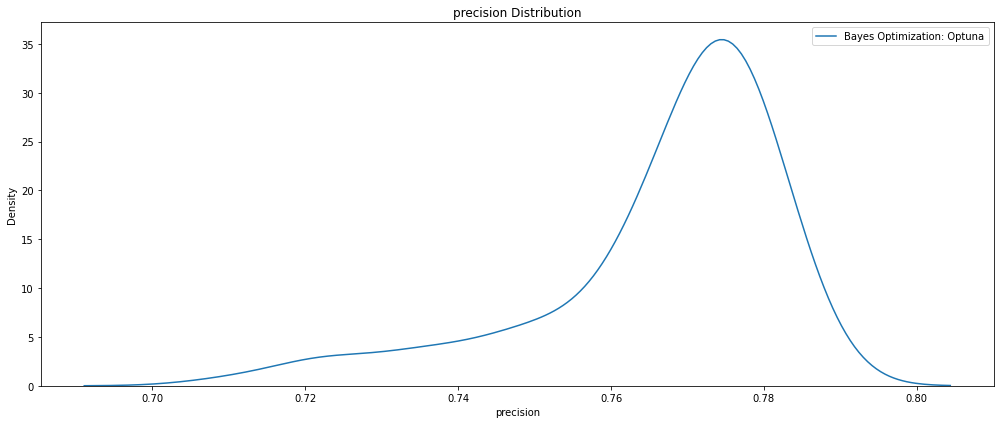

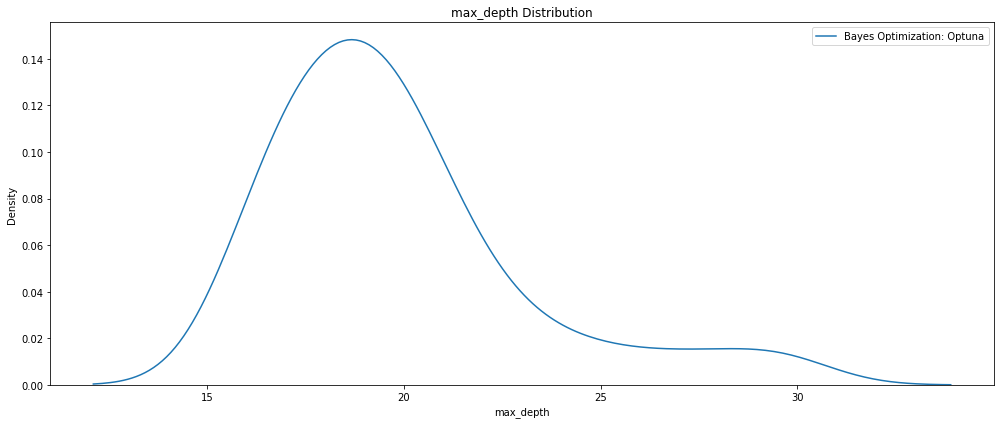

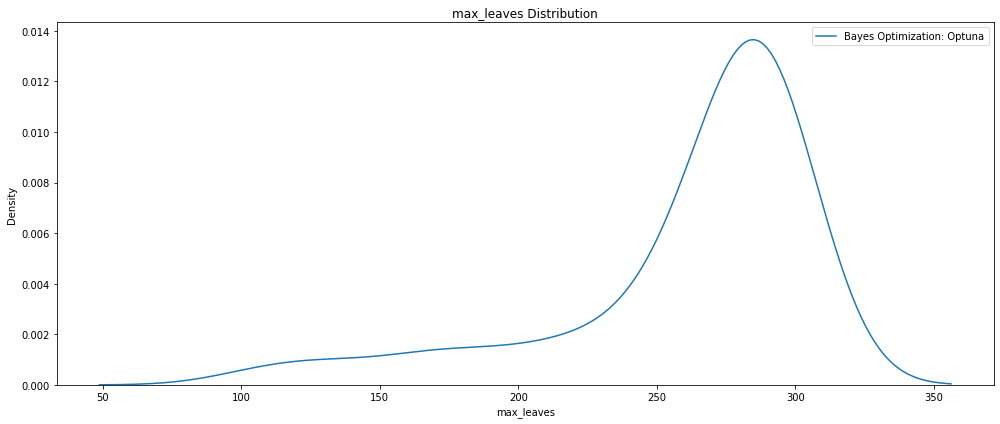

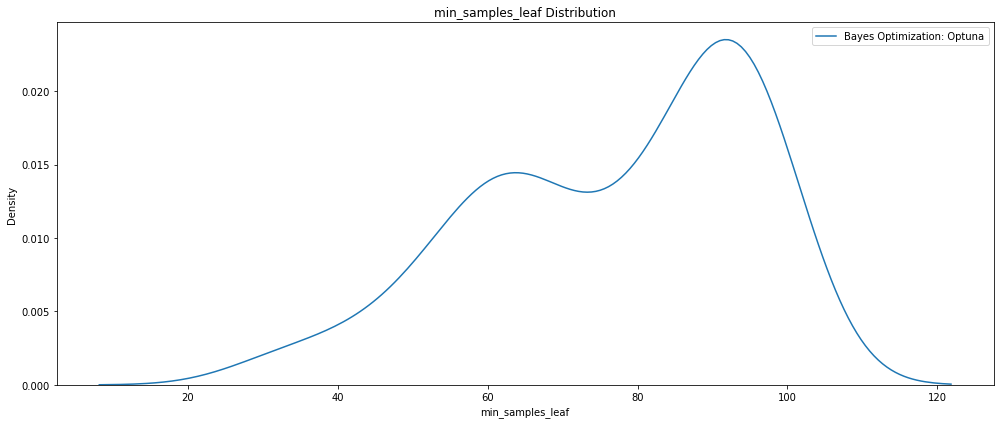

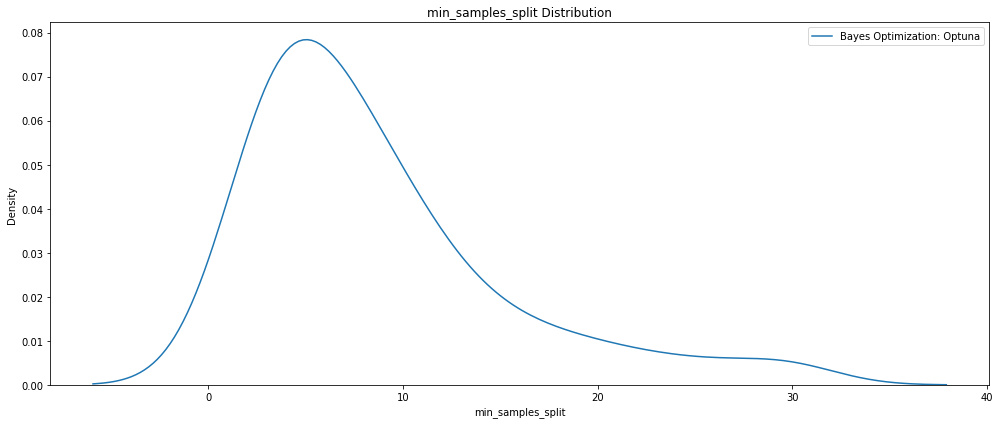

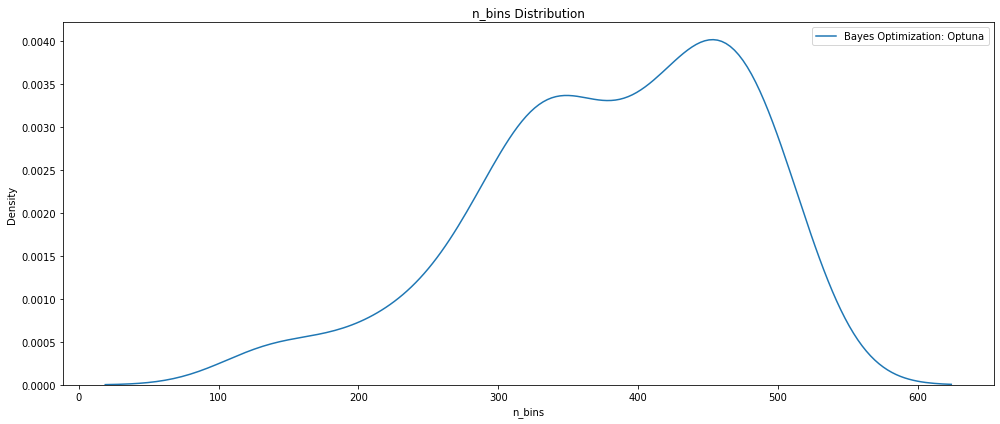

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'datetime_start', 'datetime_complete',
                   'duration','n_estimators', 'state']:
        plt.figure(figsize=(14,6))
        # Plot the random search distribution and the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label='Bayes Optimization: Optuna')
            plt.legend(loc = 0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

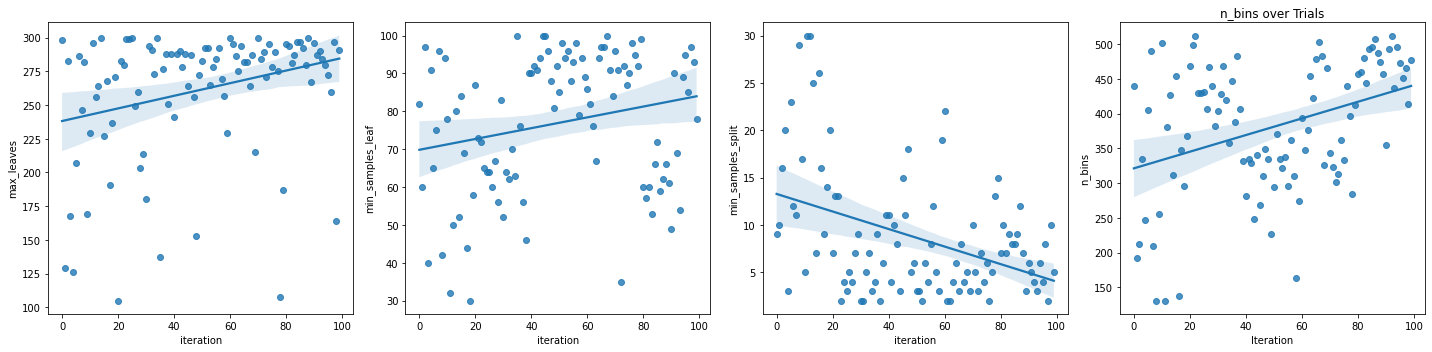

In [ ]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(1, 4, figsize=(20,5))
i = 0
axs = axs.flatten()
for i, hpo in enumerate(['max_leaves', 'min_samples_leaf', 'min_samples_split',
                         'n_bins']): 
                         # Scatterplot
                         sns.regplot('iteration', hpo, data=trials_df, ax=axs[i]) 
                         axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo),  
                                    title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

In [ ]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_RF_Optuna_US_100_GPU_Precision.html')
fig.show()

In [ ]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_RF_Optuna_US_100_GPU_Precision.html')
fig.show()

In [ ]:
# Arrange best parameters to fit model for model metrics
params = study.best_params   
params['random_state'] = seed_value
params

{'max_depth': 19,
 'max_leaves': 288,
 'min_samples_leaf': 90,
 'min_samples_split': 11,
 'n_bins': 331,
 'n_estimators': 448,
 'random_state': 42}

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/RF/Optuna/TrainTest/Model_PKL/

/content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_PKL


In [ ]:
# Set up train/test split
X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')
X_train = X_train.astype('float32')

X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')
X_test = X_test.astype('float32')

In [ ]:
# Re-create the best model and train on the training data
best_model = RandomForestClassifier(n_streams=1, 
                                    **params)

# Fit the model
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'RF_Optuna_US_trials100_GPU_Precision.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('RF_Optuna_US_trials100_GPU_Precision.pkl')
# print(model)
# =============================================================================

In [ ]:
print('\nModel Metrics for RF HPO US 100trials GPU Precision')
# Predict based on training 
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

print('\n')
print('Classification Report:')
clf_rpt = classification_report(asnumpy(y_test), asnumpy(y_test_pred))
print(clf_rpt)
print('\n')
print('Confusion matrix:')
print(confusion_matrix(asnumpy(y_test), asnumpy(y_test_pred)))
print('\n')
print('Accuracy score : %.3f' % accuracy_score(asnumpy(y_test), 
                                               asnumpy(y_test_pred)))
print('Precision score : %.3f' % precision_score(asnumpy(y_test), 
                                                 asnumpy(y_test_pred)))
print('Recall score : %.3f' % recall_score(asnumpy(y_test), 
                                           asnumpy(y_test_pred)))
print('F1 score : %.3f' % f1_score(asnumpy(y_test), asnumpy(y_test_pred)))


Model Metrics for RF HPO US 100trials GPU Precision


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98    377848
           1       0.79      0.91      0.84     54625

    accuracy                           0.96    432473
   macro avg       0.89      0.94      0.91    432473
weighted avg       0.96      0.96      0.96    432473



Confusion matrix:
[[364284  13564]
 [  5069  49556]]


Accuracy score : 0.957
Precision score : 0.785
Recall score : 0.907
F1 score : 0.842


In [ ]:
# Evaluate on the testing data 
print('The best model from US 100 Precision GPU trials optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(asnumpy(y_test), 
                                                                                                                                 asnumpy(y_test_pred))))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from US 100 Precision GPU trials optimization scores 0.93565 AUC ROC on the test set.
This was achieved using these conditions:
iteration                                    39
precision                              0.785108
datetime_start       2022-06-14 14:44:59.919133
datetime_complete    2022-06-14 14:47:06.839862
duration                 0 days 00:02:06.920729
max_depth                                    19
max_leaves                                  288
min_samples_leaf                             90
min_samples_split                            11
n_bins                                      331
n_estimators                                448
state                                  COMPLETE
Name: 39, dtype: object


### 300 Trials

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/RF/Optuna/TrainTest/Model_PKL

# Define a name for the trials
study_name = 'dask_rf_optuna_US_300_Precision_tpe'

/content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_PKL


In [ ]:
# Define objective function with the parameters to be tested
def objective(trial, X_param, y_param):

    joblib.dump(study, 'RF_Optuna_US_300_GPU_Precision.pkl')

    # Search parameters
    n_estimators = trial.suggest_int('n_estimators', 250, 500) 
    max_depth = trial.suggest_int('max_depth', 25, 50) 
    max_leaves = trial.suggest_int('max_leaves', 250, 500) 
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 80, 150)
    min_samples_split = trial.suggest_int('min_samples_split', 5, 20) 
    n_bins = trial.suggest_int('n_bins', 400, 700)
    
    score = train_and_eval(X_param,
                           y_param,
                           bootstrap=True, 
                           n_estimators=n_estimators,
                           max_depth=max_depth,
                           max_leaves=max_leaves, 
                           min_samples_leaf=min_samples_leaf,
                           min_samples_split=min_samples_split, 
                           n_bins=n_bins)

    return score

In [ ]:
with timed('dask_optuna'):
    # Begin HPO trials 
    # Start timer for experiment
    start_time = datetime.now()
    print('%-20s %s' % ('Start Time', start_time))
    if os.path.isfile('RF_Optuna_US_300_GPU_Precision.pkl'): 
      study = joblib.load('RF_Optuna_US_300_GPU_Precision.pkl')
    else: 
      study = optuna.create_study(sampler=optuna.samplers.TPESampler(), 
                                  study_name=study_name,
                                  direction='maximize')
      
    # Optimize in parallel on Dask cluster
    with parallel_backend('dask'):
        study.optimize(lambda trial: objective(trial, X_train, y_train), 
                       n_trials=300,
                       n_jobs=n_workers)

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Highest Precision score', study.best_value)

Start Time           2022-06-15 01:51:41.053965
- Trial time: 94.34259474600003
- Trial precision score: 0.8116107557760084
######################################################
- Trial time: 93.6117020979998
- Trial precision score: 0.8105057096247961
######################################################
- Trial time: 88.01434741100002
- Trial precision score: 0.8056414657447739
######################################################
- Trial time: 93.52556679100007
- Trial precision score: 0.8061775435751926
######################################################
- Trial time: 89.34205893799981
- Trial precision score: 0.8126704220752714
######################################################
- Trial time: 85.35901715399996
- Trial precision score: 0.8119447347792004
######################################################
- Trial time: 90.90675130099999
- Trial precision score: 0.8083609540521219
######################################################
- Trial time: 98.72309815800008
- Tr

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/RF/Optuna/TrainTest/trialOptions/

/content/drive/MyDrive/LoanStatus/ML/RF/Optuna/trialOptions


In [ ]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number':'iteration'}, inplace=True)
trials_df.rename(columns={'value':'precision'},inplace=True)
trials_df.rename(columns={'params_max_depth':'max_depth'}, inplace=True)
trials_df.rename(columns={'params_max_leaves':'max_leaves'}, inplace=True)
trials_df.rename(columns={'params_min_samples_leaf':'min_samples_leaf'}, 
                 inplace=True)
trials_df.rename(columns={'params_min_samples_split':'min_samples_split'}, 
                 inplace=True)
trials_df.rename(columns={'params_n_bins':'n_bins'}, inplace=True)
trials_df.rename(columns={'params_n_estimators':'n_estimators'}, inplace=True)

# Write processed data to csv
trials_df = trials_df.sort_values('precision', ascending=False)
trials_df.to_csv('RF_Optuna_US_300_GPU_Precision.csv', index=False)
print(trials_df) 

     iteration  precision             datetime_start  \
90          90   0.820849 2022-06-14 19:59:06.894844   
211        211   0.820200 2022-06-14 23:34:30.068995   
290        290   0.820137 2022-06-15 02:07:46.623245   
218        218   0.819766 2022-06-14 23:45:02.904318   
0            0   0.818967 2022-06-14 17:20:47.136692   
..         ...        ...                        ...   
4            4   0.774592 2022-06-14 17:28:17.732509   
8            8   0.772693 2022-06-14 17:34:55.774382   
70          70   0.769974 2022-06-14 19:24:26.174592   
20          20   0.761486 2022-06-14 17:55:56.360729   
279        279        NaN 2022-06-15 01:18:58.132847   

             datetime_complete               duration  max_depth  max_leaves  \
90  2022-06-14 20:01:06.415937 0 days 00:01:59.521093       40.0       500.0   
211 2022-06-14 23:36:01.966615 0 days 00:01:31.897620       37.0       495.0   
290 2022-06-15 02:10:05.312197 0 days 00:02:18.688952       35.0       488.0   
218 202

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/RF/Optuna/TrainTest/Model_Explanations/

/content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_Explanations


In [ ]:
# Plot_optimization_history: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_RF_Optuna_US_300_GPU_Precision.html')
fig.show()

In [ ]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_RF_Optuna_US_300_GPU_Precision.html')
fig.show()

In [ ]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_RF_Optuna_US_300_GPU_Precision.html')
fig.show()

In [ ]:
# plot_contour: plots parameter interactions on an interactive chart. 
fig = optuna.visualization.plot_contour(study, params=['max_leaves', 
                                                       'min_samples_leaf',
                                                       'max_depth', 
                                                       'min_samples_split'])
py.plot(fig, filename='contour_RF_Optuna_US_300_GPU_Precision.html')
fig.show()

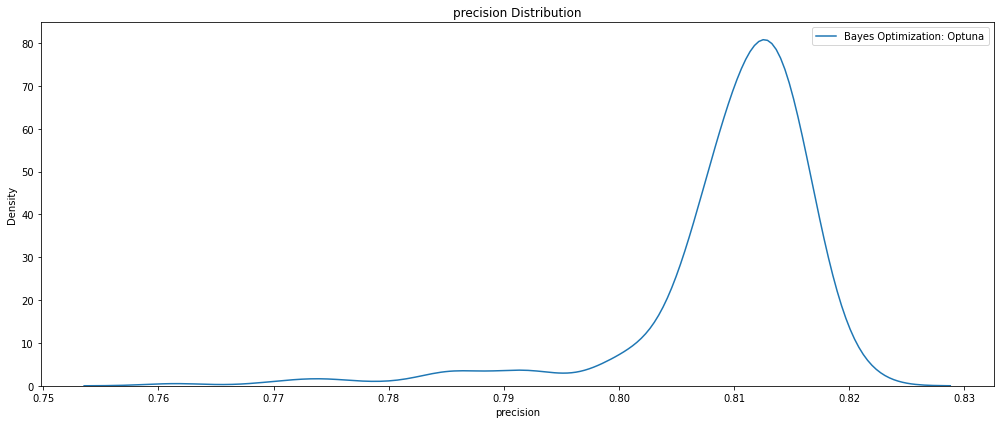

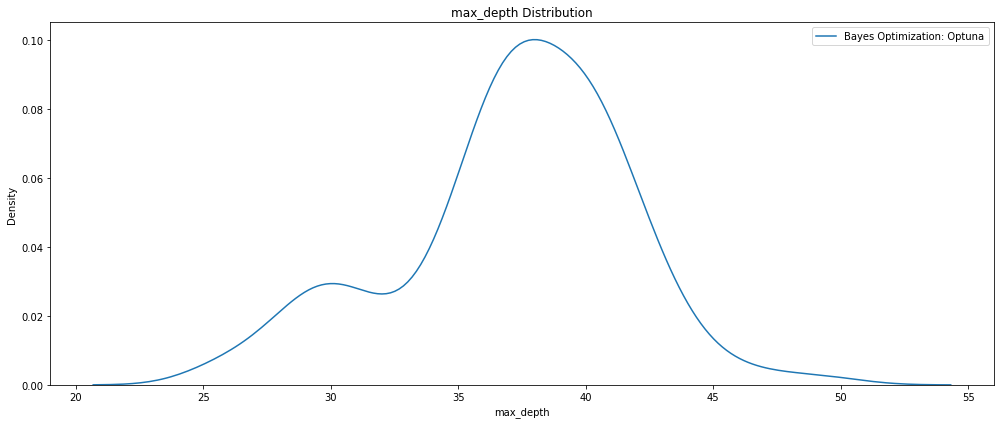

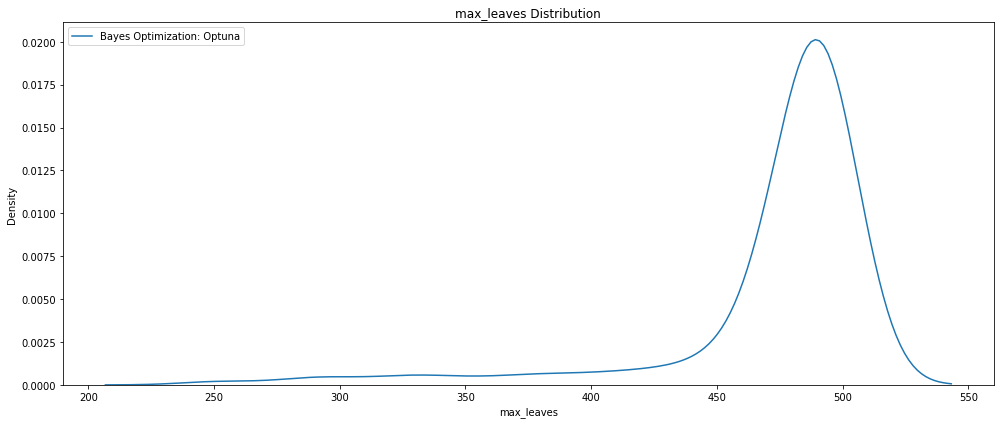

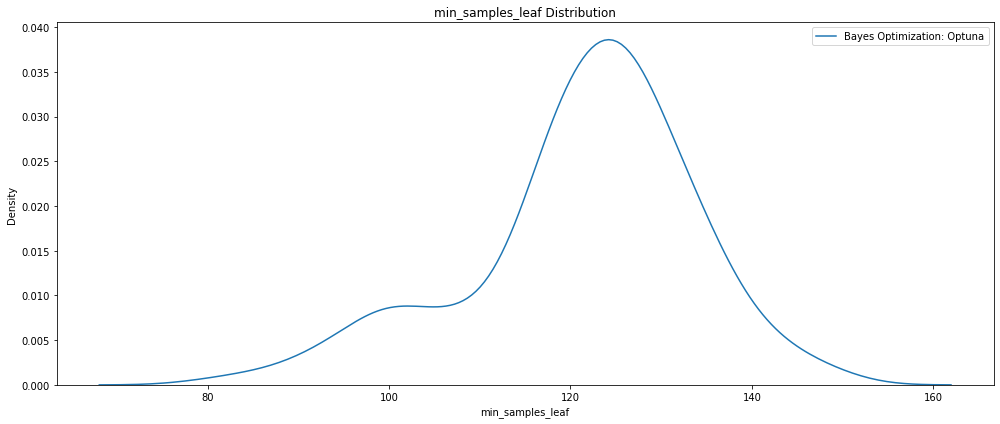

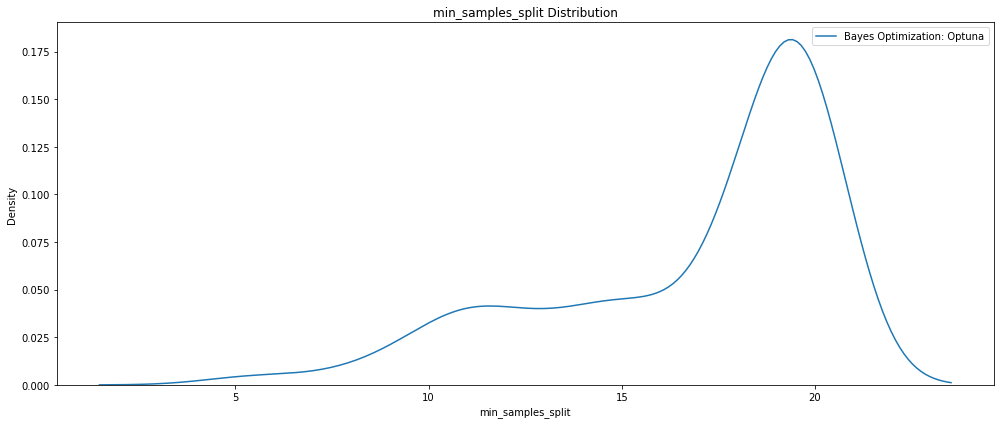

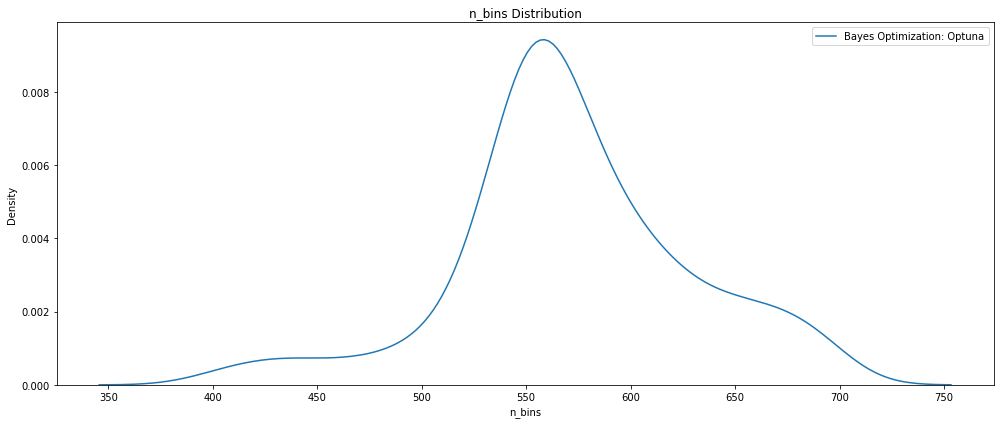

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'datetime_start', 'datetime_complete',
                   'duration','n_estimators', 'state']:
        plt.figure(figsize=(14,6))
        # Plot the random search distribution and the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label='Bayes Optimization: Optuna')
            plt.legend(loc = 0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

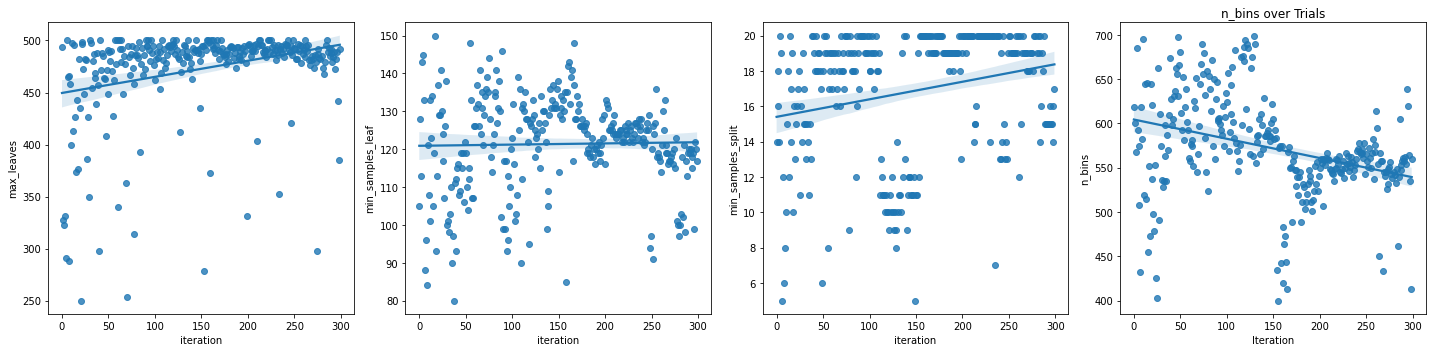

In [ ]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(1, 4, figsize=(20,5))
i = 0
axs = axs.flatten()
for i, hpo in enumerate(['max_leaves', 'min_samples_leaf', 'min_samples_split',
                         'n_bins']): 
                         # Scatterplot
                         sns.regplot('iteration', hpo, data=trials_df, ax=axs[i]) 
                         axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo),  
                                    title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

In [ ]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_RF_Optuna_US_300_GPU_Precision.html')
fig.show()

In [ ]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_RF_Optuna_US_300_GPU_Precision.html')
fig.show()

In [ ]:
# Arrange best parameters to fit model for model metrics
params = study.best_params   
params['random_state'] = seed_value
params

{'max_depth': 40,
 'max_leaves': 500,
 'min_samples_leaf': 99,
 'min_samples_split': 20,
 'n_bins': 605,
 'n_estimators': 397,
 'random_state': 42}

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/RF/Optuna/TrainTest/Model_PKL/

/content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_PKL


In [ ]:
# Set up train/test split
X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')
X_train = X_train.astype('float32')

X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')
X_test = X_test.astype('float32')

In [ ]:
# Re-create the best model and train on the training data
best_model = RandomForestClassifier(n_streams=1, 
                                    **params)

# Fit the model
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'RF_Optuna_US_trials300_GPU_Precision.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('RF_Optuna_US_trials300_GPU_Precision.pkl')
# print(model)
# =============================================================================

In [ ]:
print('\nModel Metrics for RF HPO US 300trials GPU Precision')
# Predict based on training 
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

print('\n')
print('Classification Report:')
clf_rpt = classification_report(asnumpy(y_test), asnumpy(y_test_pred))
print(clf_rpt)
print('\n')
print('Confusion matrix:')
print(confusion_matrix(asnumpy(y_test), asnumpy(y_test_pred)))
print('\n')
print('Accuracy score : %.3f' % accuracy_score(asnumpy(y_test), 
                                               asnumpy(y_test_pred)))
print('Precision score : %.3f' % precision_score(asnumpy(y_test), 
                                                 asnumpy(y_test_pred)))
print('Recall score : %.3f' % recall_score(asnumpy(y_test), 
                                           asnumpy(y_test_pred)))
print('F1 score : %.3f' % f1_score(asnumpy(y_test), asnumpy(y_test_pred)))


Model Metrics for RF HPO US 300trials GPU Precision


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98    377848
           1       0.81      0.91      0.86     54625

    accuracy                           0.96    432473
   macro avg       0.90      0.94      0.92    432473
weighted avg       0.96      0.96      0.96    432473



Confusion matrix:
[[366275  11573]
 [  4871  49754]]


Accuracy score : 0.962
Precision score : 0.811
Recall score : 0.911
F1 score : 0.858


In [ ]:
# Evaluate on the testing data 
print('The best model from US 300 Precision GPU trials optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(asnumpy(y_test), 
                                                                                                                                 asnumpy(y_test_pred))))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from US 300 Precision GPU trials optimization scores 0.94010 AUC ROC on the test set.
This was achieved using these conditions:
iteration                                    90
precision                              0.820849
datetime_start       2022-06-14 19:59:06.894844
datetime_complete    2022-06-14 20:01:06.415937
duration                 0 days 00:01:59.521093
max_depth                                  40.0
max_leaves                                500.0
min_samples_leaf                           99.0
min_samples_split                          20.0
n_bins                                    605.0
n_estimators                              397.0
state                                  COMPLETE
Name: 90, dtype: object
